In [1]:
import subprocess, os
import polars as pl
import pandas as pd
from plotnine import *
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(10000)  # or a large enough number for your table
pl.Config.set_tbl_width_chars(200)  # widen output if needed
pl.Config.set_tbl_cols(100)  # show all columns

root = "/home/jovyan/git/Collect&AnalyzeFinalProject"
events = pl.read_parquet(
    os.path.join(root, "DATA_NTBS/processed.parquet"),
)

In [2]:
MARKET = "SPY"
MANUFACTURERS = [
    "BA",
    "EADSY",
]


# OPTIONAL: add airline tickers later if you want
AIRLINES = ["AF.PA", "020560.KS", "PGSUS.IS", " 089590.KQ", "LHA.DE", "LUV", "CEA"]
MANU_MAP = {
    "BOEING": "BA",
    "AIRBUS": "EADSY",
    "AIRBUS INDUSTRIE": "EADSY",
    "AIR FRANCE": "AF.PA",
    "ASIANA AIRLINES": "020560.KS",
    "PEGASUS AIRLINES": "PGSUS.IS",
    "JEJU AIR": "089590.KQ",
    "LUFTHANSA": "LHA.DE",
    "SOUTHWEST AIRLINES CO": "LUV",
    "CHINA EASTERN AIRLINES": "CEA",
}
TICKERS = sorted(set([MARKET] + MANUFACTURERS + AIRLINES))
INJURY_COUNT_THRESH = 100

stock_to_index = {
    "INDIGO.NS": "^NSEI",  # NIFTY 50 (India)
    "BLUEDART.NS": "^NSEI",  # NIFTY 50 (India)
    "BA": "^GSPC",  # S&P 500 (US)
    "GE": "^GSPC",  # S&P 500 (US)
    # From your manu/oper table:
    "EADSY": "^GSPC",  # Airbus ADR trades in US → S&P 500
    "AF.PA": "^FCHI",  # CAC 40 (France)
    "020560.KS": "^KS11",  # Asiana Airlines — KOSPI (Korea, KSE)
    "LHA.DE": "^GDAXI",  # Lufthansa — DAX (Germany)
    "LUV": "^GSPC",  # Southwest — S&P 500 (US)
    "PGSUS.IS": "XU100.IS",  # Pegasus — BIST 100 (Turkey)
    "CEA": "^GSPC",  # China Eastern ADR (NYSE) → S&P 500
    "089590.KQ": "^KQ11",  # JEJU Air — KOSDAQ (Korea)
}


##### events processed

In [3]:
events = events.filter(pl.col("inj_all_tot") > INJURY_COUNT_THRESH)
reduced_events = events.select(
    pl.col(["acft_make", "oper_name", "ev_date", "inj_all_tot"])
).sort("inj_all_tot", descending=True)

ev = (
    reduced_events.with_columns(
        ev_date=pl.col("ev_date").cast(pl.Datetime).alias("ev_date"),
        oper_name_cap=pl.col("oper_name").str.to_uppercase().str.strip_chars(),
        manu_name_cap=pl.col("acft_make").str.to_uppercase().str.strip_chars(),
    )
    .with_columns(
        manu_ticker=pl.col("manu_name_cap")
        .map_elements(lambda s: MANU_MAP.get(s, None))
        .alias("manu_ticker"),
        oper_ticker=pl.col("oper_name_cap")
        .map_elements(lambda s: MANU_MAP.get(s, "") if s is not None else "")
        .alias("oper_ticker"),
    )
    .select("ev_date", "manu_ticker", "oper_ticker", "oper_name_cap", "manu_name_cap")
    .drop_nulls(
        subset=[
            "manu_ticker",
            "oper_ticker",
        ]
    )
    .sort(["ev_date"])
)
ev = ev.with_columns(
    oper_ticker=pl.when(pl.col("oper_name_cap") == "AIR INDIA CHARTERS")
    .then(pl.lit("BLUEDART.NS"))
    .otherwise(pl.col("oper_ticker"))
)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


#### stock prices processed

In [4]:
# # 3) Date range from events (pad ±365 days)

min_date = pd.Timestamp(reduced_events.select(pl.col("ev_date").min()).item())
max_date = pd.Timestamp(reduced_events.select(pl.col("ev_date").max()).item())
start = (min_date - pd.Timedelta(days=365)).date().isoformat()
end = (max_date + pd.Timedelta(days=365)).date().isoformat()
# print(f"Downloading {TICKERS} from {start} to {end}")

# # 4) Download adjusted data (auto_adjust=True => Close is adjusted)
# px = yf.download(TICKERS, start=start, end=end, auto_adjust=True, progress=False)

# # Normalize to long tidy form with pandas (yfinance returns wide)
# if isinstance(px.columns, pd.MultiIndex):
#     # take the 'Close' level only
#     px = px["Close"].copy()
# else:
#     # single ticker case
#     px = px[["Close"]]

# px = px.rename_axis("date").reset_index()
# prices_long = px.melt(id_vars="date", var_name="ticker", value_name="close").dropna()
# prices_long["date"] = pd.to_datetime(prices_long["date"])
# prices_long = prices_long.sort_values(["ticker", "date"])

# # 5) Compute simple daily returns (optional but handy)
# prices_long["ret"] = prices_long.groupby("ticker")["close"].pct_change()

# # 6) Save outputs using polars
# prices = pl.from_pandas(prices_long)
# root = os.path.join(os.getcwd(), "data")
# prices.write_parquet(os.path.join(root, "stocks/prices.parquet"))

In [5]:
prices = pl.read_parquet(os.path.join(root, "prices.parquet"))

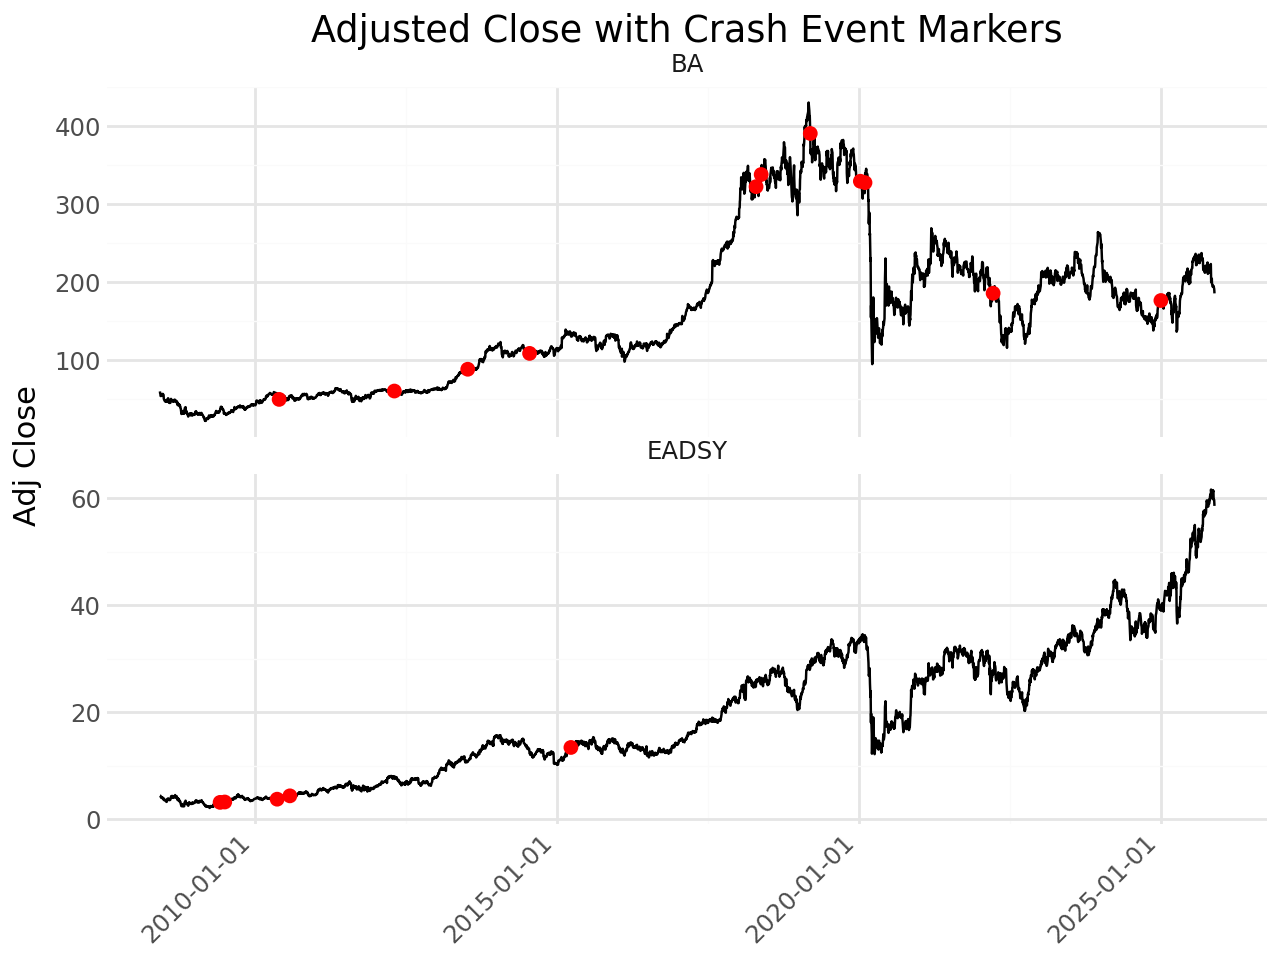

In [6]:
# ---------------------------
# 3) ALIGN EVENT DATES TO FIRST TRADING DAY ≥ ev_date PER TICKER (forward-asof)
# ---------------------------
TICKER_LIST = MANUFACTURERS
COL_NAME = "manu_ticker"
points_list = []
P = prices.filter(pl.col("ticker").is_in(TICKER_LIST))

for tkr in ev.select(COL_NAME).unique().to_series().to_list():
    ev_t = ev.filter(pl.col(COL_NAME) == tkr).sort("ev_date")
    px_t = P.filter(pl.col("ticker") == tkr).rename({"date": "px_date"}).sort("px_date")
    if ev_t.height == 0 or px_t.height == 0:
        continue

    # ensure px_date uses the same datetime unit as ev_date (ev_date is typically μs here)
    px_t = px_t.with_columns(px_date=pl.col("px_date").cast(pl.Datetime("us")))

    # forward asof join: event time -> next trading date for that ticker
    pts = ev_t.join_asof(
        px_t, left_on="ev_date", right_on="px_date", strategy="forward"
    )
    pts = (
        pts.drop_nulls(subset=["px_date"])
        .rename({"px_date": "date"})
        .select("date", "ticker", "close")
        .sort("date")
    )
    points_list.append(pts)

points = (
    pl.concat(points_list, how="vertical")
    if points_list
    else pl.DataFrame({"date": [], "ticker": [], "close": []})
)

# ---------------------------
# 4) PLOT: LINE PER TICKER + POINTS AT CRASHES (facets)
#    Use a single column of facets (ncol=1) so each ticker gets a full-width row.
#    Dynamically adjust figure height so each row is larger.
# ---------------------------
# compute number of tickers to determine figure height
n_tickers = max(1, P.select(pl.col("ticker")).unique().height)
per_plot_height = 3.5  # inches per ticker row, adjust to taste
fig_height = max(6, n_tickers * per_plot_height)
plt.rcParams["figure.figsize"] = (12, fig_height)

p = (
    ggplot(P.to_pandas(), aes(x="date", y="close"))
    + geom_line()
    + (
        geom_point(points.to_pandas(), aes(x="date", y="close"), size=2, color="red")
        if points.height > 0
        else None
    )
    + facet_wrap("~ ticker", scales="free_y", ncol=1)
    + labs(title="Adjusted Close with Crash Event Markers", x="", y="Adj Close")
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)

p


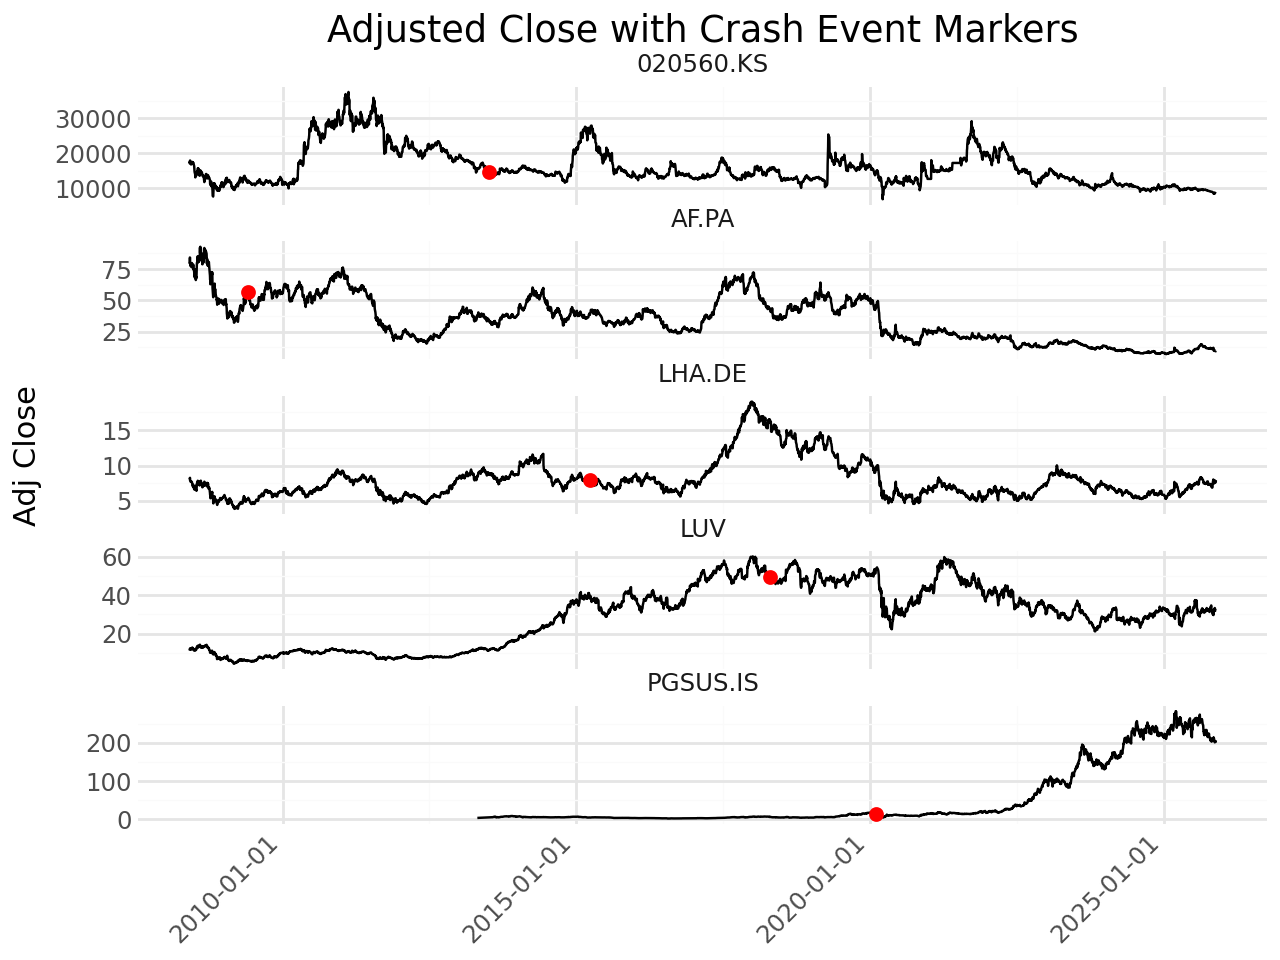

In [7]:
# ---------------------------
# 3) ALIGN EVENT DATES TO FIRST TRADING DAY ≥ ev_date PER TICKER (forward-asof)
# ---------------------------
TICKER_LIST = AIRLINES
COL_NAME = "oper_ticker"
points_list = []
P = prices.filter(pl.col("ticker").is_in(TICKER_LIST))

for tkr in ev.select(COL_NAME).unique().to_series().to_list():
    ev_t = ev.filter(pl.col(COL_NAME) == tkr).sort("ev_date")
    px_t = P.filter(pl.col("ticker") == tkr).rename({"date": "px_date"}).sort("px_date")
    if ev_t.height == 0 or px_t.height == 0:
        continue

    # ensure px_date uses the same datetime unit as ev_date (ev_date is typically μs here)
    px_t = px_t.with_columns(px_date=pl.col("px_date").cast(pl.Datetime("us")))

    # forward asof join: event time -> next trading date for that ticker
    pts = ev_t.join_asof(
        px_t, left_on="ev_date", right_on="px_date", strategy="forward"
    )
    pts = (
        pts.drop_nulls(subset=["px_date"])
        .rename({"px_date": "date"})
        .select("date", "ticker", "close")
        .sort("date")
    )
    points_list.append(pts)

points = (
    pl.concat(points_list, how="vertical")
    if points_list
    else pl.DataFrame({"date": [], "ticker": [], "close": []})
)

# ---------------------------
# 4) PLOT: LINE PER TICKER + POINTS AT CRASHES (facets)
#    Use a single column of facets (ncol=1) so each ticker gets a full-width row.
#    Dynamically adjust figure height so each row is larger.
# ---------------------------
# compute number of tickers to determine figure height
n_tickers = max(1, P.select(pl.col("ticker")).unique().height)
per_plot_height = 3.5  # inches per ticker row, adjust to taste
fig_height = max(6, n_tickers * per_plot_height)
plt.rcParams["figure.figsize"] = (12, fig_height)

p = (
    ggplot(P.to_pandas(), aes(x="date", y="close"))
    + geom_line()
    + (
        geom_point(points.to_pandas(), aes(x="date", y="close"), size=2, color="red")
        if points.height > 0
        else None
    )
    + facet_wrap("~ ticker", scales="free_y", ncol=1)
    + labs(title="Adjusted Close with Crash Event Markers", x="", y="Adj Close")
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, ha="right"))
)
p


##### index prices processed

In [8]:
# min_date = pd.Timestamp(reduced_events.select(pl.col("ev_date").min()).item())
# max_date = pd.Timestamp(reduced_events.select(pl.col("ev_date").max()).item())
# start = (min_date - pd.Timedelta(days=365)).date().isoformat()
# end = (max_date + pd.Timedelta(days=365)).date().isoformat()

# px = yf.download(list(set(stock_to_index.values())), start=start, end=end)
# # Normalize to long tidy form with pandas (yfinance returns wide)
# if isinstance(px.columns, pd.MultiIndex):
#     # take the 'Close' level only
#     px = px["Close"].copy()
# else:
#     # single ticker case
#     px = px[["Close"]]

# px = px.rename_axis("date").reset_index()
# market_index = px.melt(id_vars="date", var_name="ticker", value_name="close").dropna()
# market_index["date"] = pd.to_datetime(market_index["date"])
# market_index = market_index.sort_values(["ticker", "date"])
# root = os.path.join(os.getcwd(), "data")
# market_index.to_parquet(os.path.join(root, "stocks/market_index.parquet"))
# market_index = market_index.sort(
#     ["ticker", "date"]
# ).with_columns(  # important: ensure chronological order per ticker
#     (pl.col("close") / pl.col("close").shift(1) - 1)
#     .over("ticker")  # compute within each ticker
#     .alias("ret")
# )

#### CAR

In [9]:
import pandas as pd
import statsmodels.api as sm

root = "/home/jovyan/git/Collect&AnalyzeFinalProject"
market_index = pl.read_parquet(os.path.join(root, "market_index.parquet"))


def compute_car(
    target_event_ts, est_window=(120, 20), event_window=5, duplicate_tickers=False
):
    """
    Compute CAR for each event (one per row in `events`).

    prices: DataFrame with ['date', 'ticker', 'close']
    stock_to_index: dict mapping stock_ticker -> index_ticker
    events: DataFrame with ['ev_date', 'ticker'] at minimum
    est_window: (start, end) days before event for estimation (e.g. (120, 20))
    event_window: +/- days around event for CAR window
    """
    # compute daily returns
    pric = prices.sort(["ticker", "date"])

    results = []

    for row_idx in range(len(target_event_ts)):
        stock = target_event_ts[row_idx]["ticker"][0]
        ev_date = target_event_ts[row_idx]["ev_date"][0]
        index_tkr = stock_to_index.get(stock)
        if index_tkr is None:
            continue

        # subset returns for stock + index
        stock_prices = pric.filter(pl.col("ticker") == stock).drop_nulls()

        # --- estimation window ---
        est_start = ev_date - pd.Timedelta(days=est_window[0])
        est_end = ev_date - pd.Timedelta(days=est_window[1])
        market_prices = (
            market_index.filter(
                (pl.col("ticker") == index_tkr)
                & (pl.col("date") >= est_start)
                & (pl.col("date") <= est_end)
            )
            .sort("date")
            .rename({"ret": "idx_ret"})
        )
        est_stock_prices = (
            stock_prices.filter(
                (pl.col("date") >= est_start) & (pl.col("date") <= est_end)
            )
            .sort("date")
            .rename({"ret": "stk_ret"})
        )
        if len(market_prices) == 0 or len(est_stock_prices) == 0:
            print(f"skipping.. {stock}")
            continue

        est = (
            est_stock_prices.join(market_prices, on="date", how="inner")
            .drop_nulls()
            .sort("date")
        )
        # Build X, y from the aligned frame
        y = est["stk_ret"].to_numpy()
        X = sm.add_constant(est["idx_ret"].to_numpy())
        if X.shape[0] != y.shape[0]:
            print(f"stock and index prices failed for {stock} & {index_tkr}")
            continue
        try:
            model = sm.OLS(y, X).fit()
        except:
            print(f"failed to regress {stock} & {index_tkr}")

        # --- event window ---
        evt_start = ev_date - pd.Timedelta(days=event_window)
        evt_end = ev_date + pd.Timedelta(days=event_window)
        # evt_df = df_pivot.loc[evt_start:evt_end].dropna()

        evt_market = (
            market_index.filter(
                (pl.col("ticker") == index_tkr)
                & (pl.col("date") >= evt_start)
                & (pl.col("date") <= evt_end)
            )
            .select(["date", "ret"])
            .rename({"ret": "idx_ret"})
            .sort("date")
        )

        evt_stock = (
            stock_prices.filter(
                (pl.col("date") >= evt_start) & (pl.col("date") <= evt_end)
            )
            .select(["date", "ret"])
            .rename({"ret": "stk_ret"})
            .sort("date")
        )

        # Align by date (inner join)
        evt = (
            evt_stock.join(evt_market, on="date", how="inner").drop_nulls().sort("date")
        )

        # If no overlapping dates, skip
        if evt.height == 0:
            continue

        # Expected/abnormal returns and CAR using fitted params
        alpha = float(model.params[0])
        beta = float(model.params[1])
        final_tkr_label = stock if not duplicate_tickers else f"{stock}_{row_idx}"
        evt = (
            evt.with_columns(
                (pl.lit(alpha) + pl.lit(beta) * pl.col("idx_ret")).alias("expected"),
            )
            .with_columns((pl.col("stk_ret") - pl.col("expected")).alias("abn_ret"))
            .with_columns(pl.col("abn_ret").cum_sum().alias("car"))
            .with_columns(
                pl.lit(final_tkr_label).alias("ticker"),
                pl.lit(ev_date).alias("ev_date"),
            )
            .select(["ev_date", "date", "ticker", "abn_ret", "car"])
        )

        # Append to results as pandas for easy concatenation later
        results.append(evt.to_pandas())

    # combine all
    return (
        pd.concat(results, ignore_index=True)
        if results
        else pd.DataFrame(columns=["ev_date", "date", "ticker", "abn_ret", "car"])
    )

skipping.. BLUEDART.NS
skipping.. CEA
skipping.. 089590.KQ


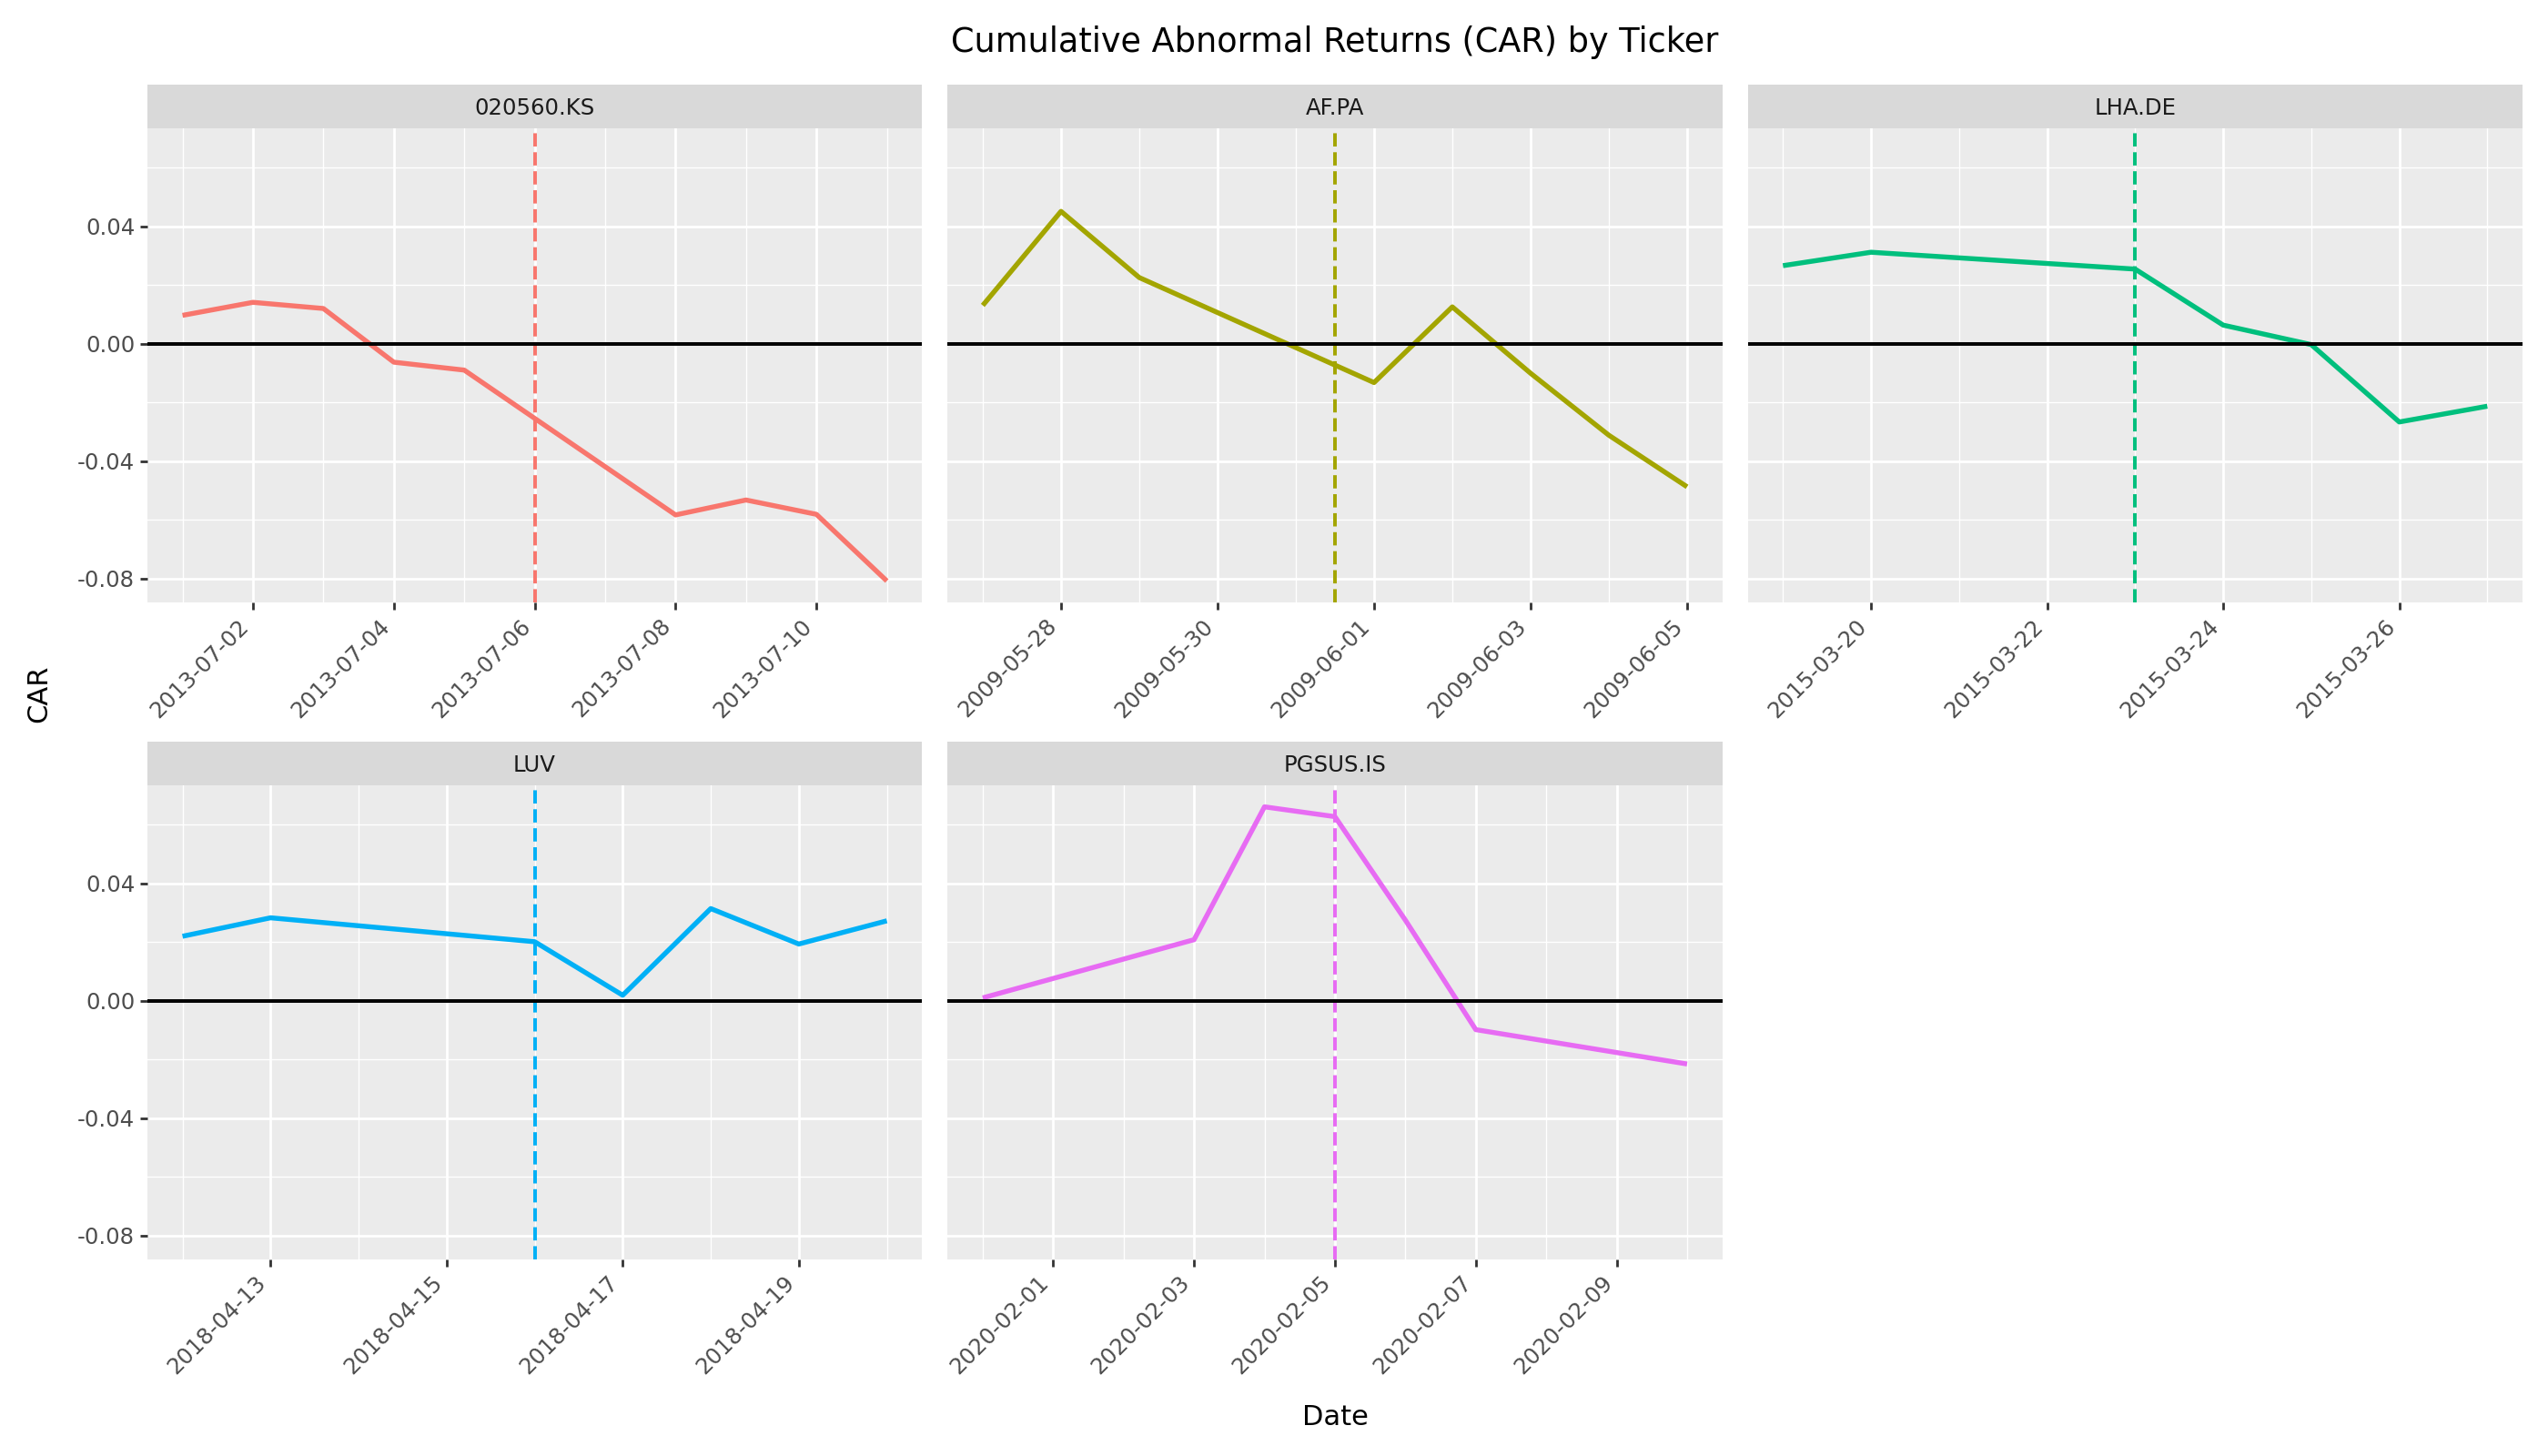

In [10]:
# --------------------------
# Airlines
# --------------------------
target = ev[["ev_date", "oper_ticker"]]
target = target.rename({"oper_ticker": "ticker"}).filter(pl.col("ticker") != "")
car_df = compute_car(target)

# compute midpoint date per ticker
midpoints = (
    car_df.groupby("ticker")["date"]
    .agg(["min", "max"])
    .assign(mid=lambda d: d["min"] + (d["max"] - d["min"]) / 2)
    .reset_index()
)

# plot with plotnine
p = (
    ggplot(car_df, aes(x="date", y="car", color="ticker", group="ticker"))
    + geom_line(size=1.1)
    # midpoint vertical line (per facet)
    + geom_vline(
        data=midpoints,
        mapping=aes(xintercept="mid", color="ticker"),
        linetype="dashed",
        size=0.8,
    )
    # horizontal zero line
    + geom_hline(yintercept=0, color="black", linetype="solid", size=0.8)
    # facets
    + facet_wrap("~ticker", scales="free_x")
    # clean theme
    + theme(
        figure_size=(14, 8),
        legend_position="none",
        axis_text_x=element_text(rotation=45, ha="right"),  # rotate x labels
    )
    + labs(title="Cumulative Abnormal Returns (CAR) by Ticker", x="Date", y="CAR")
)

p

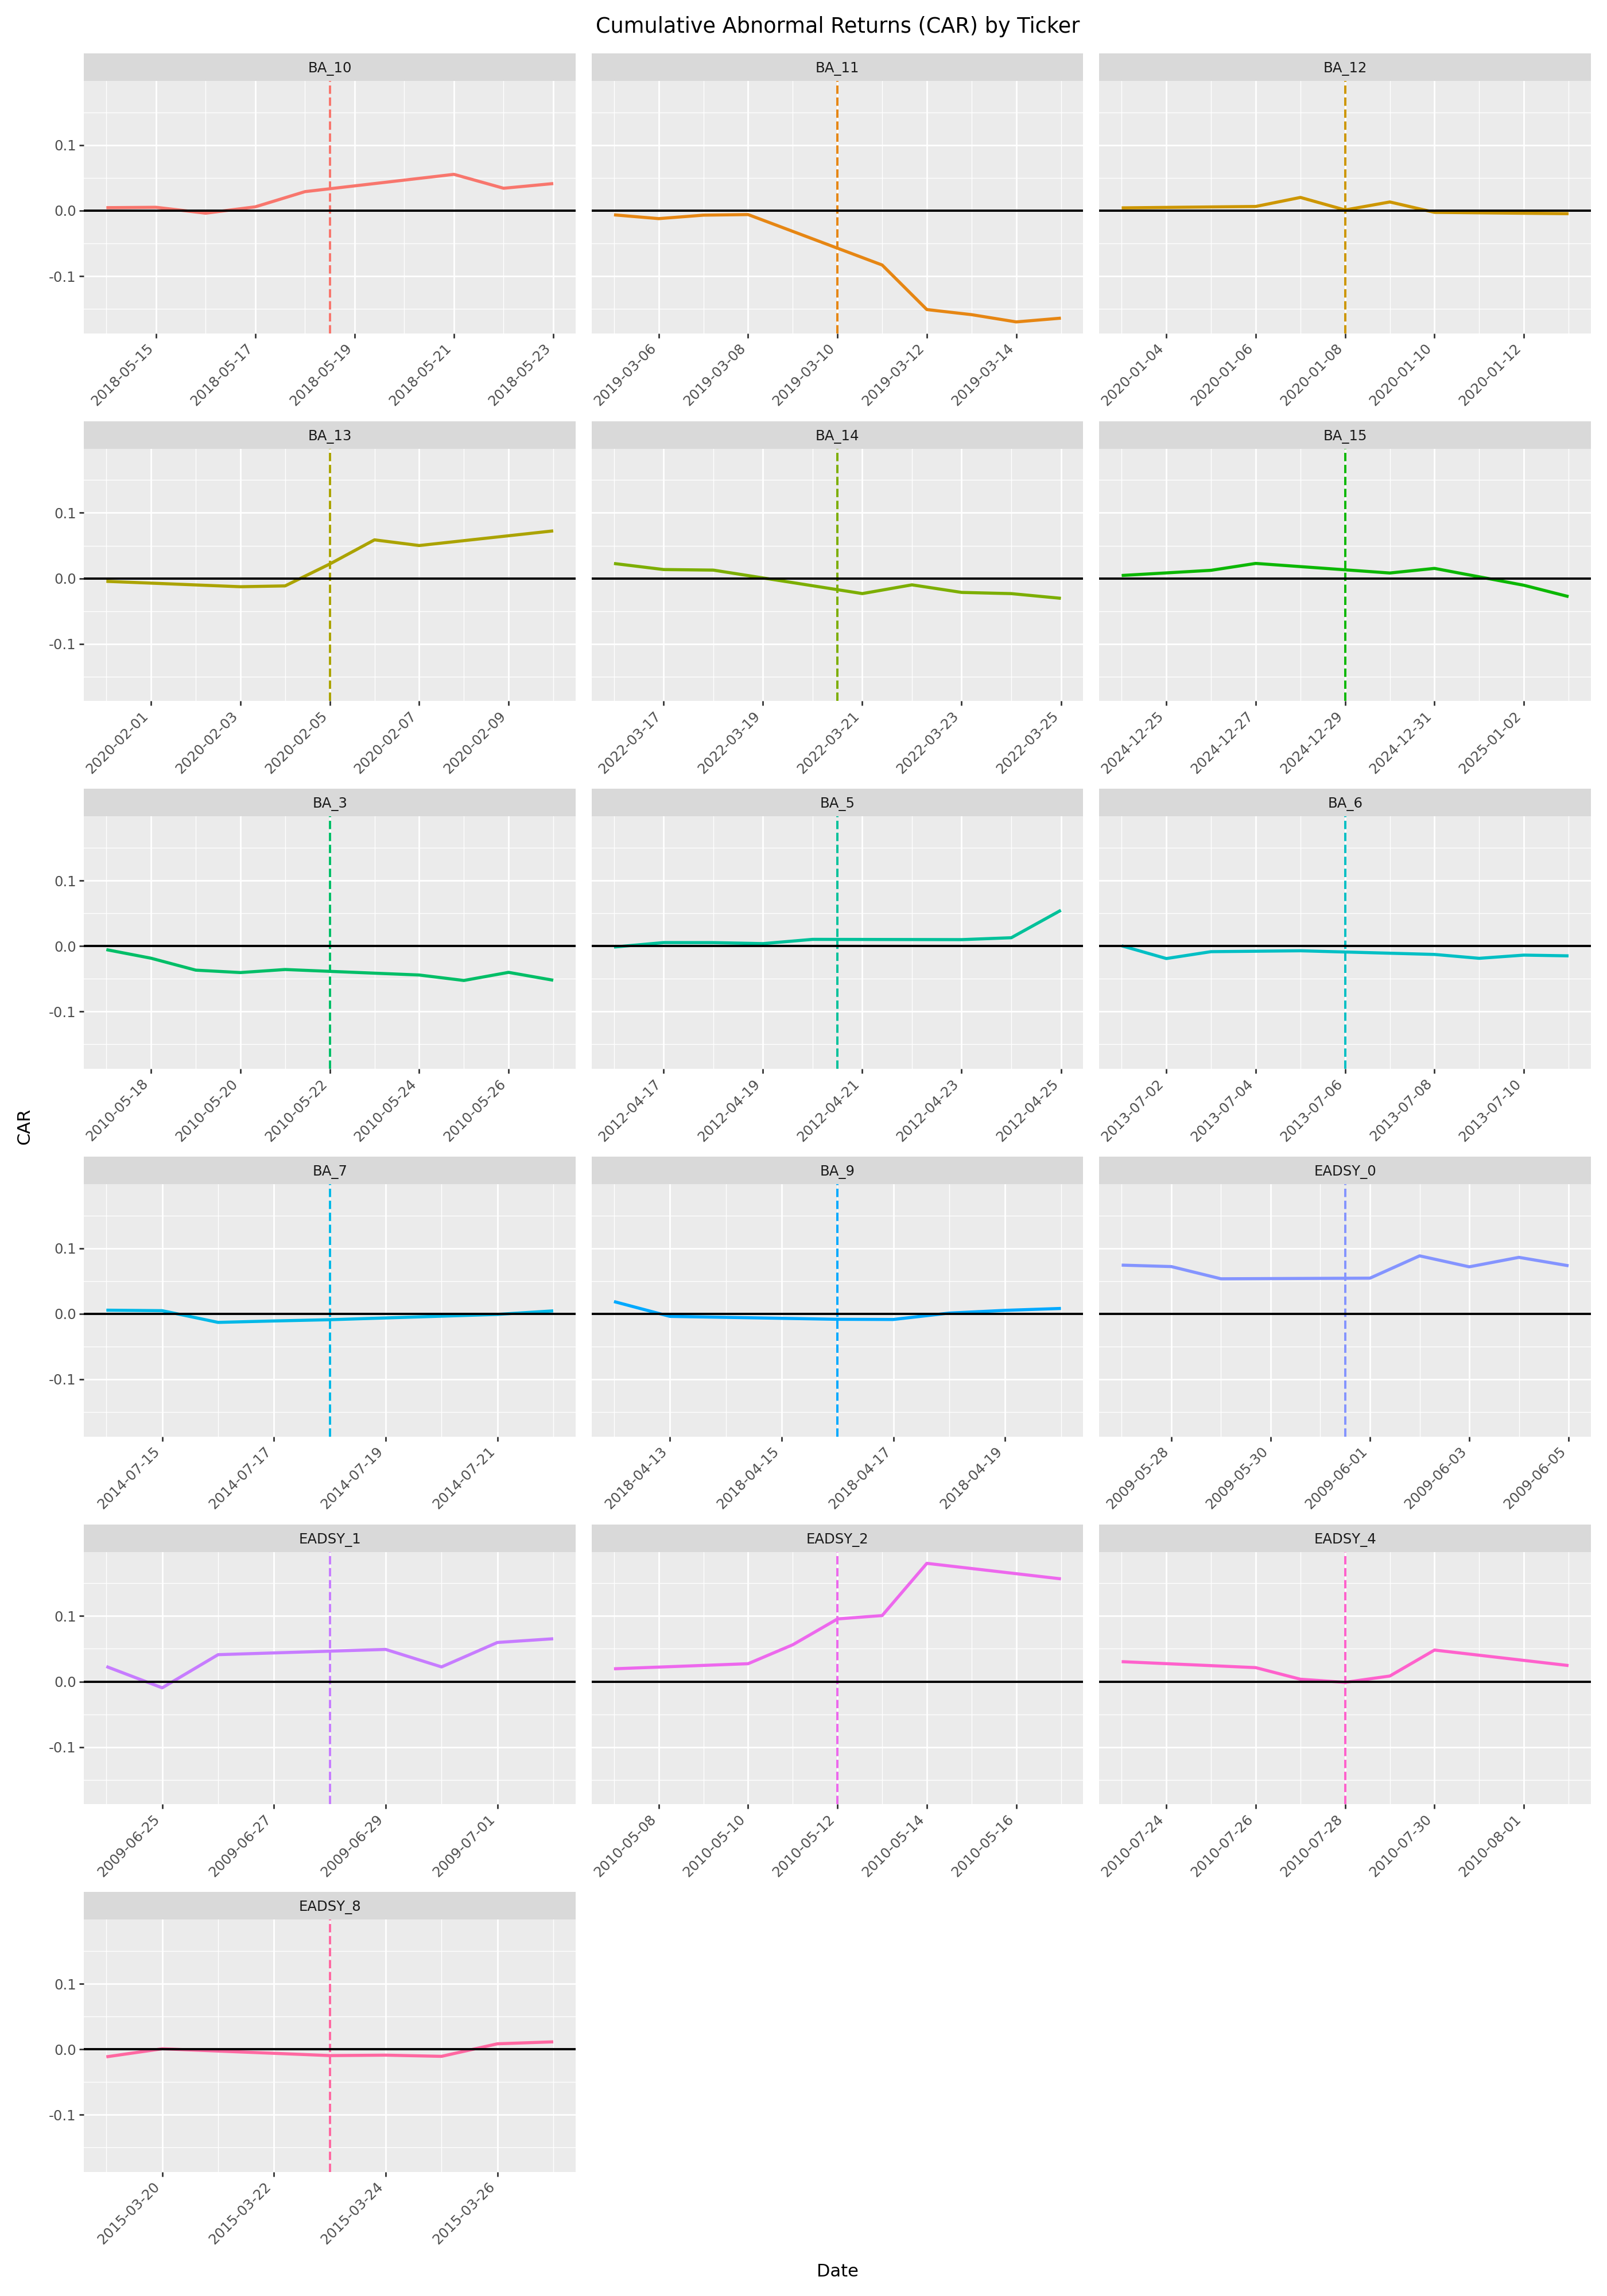

In [11]:
# --------------------------
# manufacturer
# --------------------------
target = ev[["ev_date", "manu_ticker"]]
target = target.rename({"manu_ticker": "ticker"}).filter(pl.col("ticker") != "")
# prices = pd.read_parquet("prices.parquet")   # columns: date, ticker, close

car_df = compute_car(target, duplicate_tickers=True)
# compute midpoint date per ticker
midpoints = (
    car_df.groupby("ticker")["date"]
    .agg(["min", "max"])
    .assign(mid=lambda d: d["min"] + (d["max"] - d["min"]) / 2)
    .reset_index()
)

# plot with plotnine
p = (
    ggplot(car_df, aes(x="date", y="car", color="ticker", group="ticker"))
    + geom_line(size=1.1)
    # midpoint vertical line (per facet)
    + geom_vline(
        data=midpoints,
        mapping=aes(xintercept="mid", color="ticker"),
        linetype="dashed",
        size=0.8,
    )
    # horizontal zero line
    + geom_hline(yintercept=0, color="black", linetype="solid", size=0.8)
    # facets
    + facet_wrap("~ticker", scales="free_x", ncol=3)
    # clean theme
    + theme(
        figure_size=(14, 20),
        legend_position="none",
        axis_text_x=element_text(rotation=45, ha="right"),  # rotate x labels
    )
    + labs(title="Cumulative Abnormal Returns (CAR) by Ticker", x="Date", y="CAR")
)

p


## NARROWED ANALYSIS

In [12]:
def compute_TTR(car_df, ev_date):
    """
    Time To Recovery: # of days after event until CAR >= 0.
    Returns None if CAR never recovers.
    """
    df = car_df.sort_values("date")
    after = df[df["date"] >= ev_date]
    rec = after[after["car"] >= 0]

    if len(rec) == 0:
        return None

    return int((rec.iloc[0]["date"] - ev_date).days)


In [13]:
def compute_MAE(car_df):
    """Max Adverse Excursion: minimum CAR."""
    return float(car_df["car"].min())


In [14]:
example_events = ev.head(5)
example_events


ev_date,manu_ticker,oper_ticker,oper_name_cap,manu_name_cap
datetime[μs],str,str,str,str
2009-06-01 00:00:00,"""EADSY""","""AF.PA""","""AIR FRANCE""","""AIRBUS"""
2009-06-29 00:00:00,"""EADSY""","""""","""YEMENIA""","""AIRBUS"""
2010-05-12 00:00:00,"""EADSY""","""""","""AFRIQIYAH AIRWAYS""","""AIRBUS"""
2010-05-22 00:00:00,"""BA""","""BLUEDART.NS""","""AIR INDIA CHARTERS""","""BOEING"""
2010-07-28 00:00:00,"""EADSY""","""""","""AIRBLUE""","""AIRBUS"""


In [15]:
target = example_events.rename({"oper_ticker":"ticker"})[["ev_date","ticker"]]
example_car_df = compute_car(target)


skipping.. BLUEDART.NS


In [16]:
summary_rows = []

for (ev_date, tkr), df in example_car_df.groupby(["ev_date","ticker"]):
    mae = compute_MAE(df)
    ttr = compute_TTR(df, ev_date)

    summary_rows.append({
        "event_date": ev_date,
        "ticker": tkr,
        "MAE": mae,
        "TTR": ttr,
        "CAR_day0": float(df.loc[df["date"] == ev_date, "car"].values[0])
    })

summary = pd.DataFrame(summary_rows)
summary


,event_date,ticker,MAE,TTR,CAR_day0
0,2009-06-01,AF.PA,-0.048736,1,-0.013247


In [17]:
def plot_CAR(df, ev_date, tkr):
    plt.figure(figsize=(10,5))
    plt.plot(df["date"], df["car"], label=f"CAR - {tkr}")
    plt.axvline(ev_date, linestyle="--", color="red")
    plt.title(f"CAR Around Crash — {tkr}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


In [18]:
def plot_recovery(df, ev_date, tkr):
    mae = compute_MAE(df)
    ttr = compute_TTR(df, ev_date)

    df = df.sort_values("date")
    plt.figure(figsize=(10,5))

    plt.plot(df["date"], df["car"], label=f"CAR - {tkr}", linewidth=2)
    plt.axvline(ev_date, linestyle="--", color="red", label="Crash")

    # MAE point
    mae_date = df.loc[df["car"].idxmin(), "date"]
    plt.scatter(mae_date, mae, color="black", s=50, label=f"MAE ({mae:.3f})")

    # Recovery marker
    if ttr is not None:
        rec_date = ev_date + pd.Timedelta(days=ttr)
        plt.scatter(rec_date, 0, color="green", s=60, label=f"Recovery (TTR={ttr})")

    plt.title(f"Recovery Path for {tkr}")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


In [19]:
example_car_df.head(), example_car_df.tail(), example_car_df.shape


(     ev_date       date ticker   abn_ret       car
 0 2009-06-01 2009-05-27  AF.PA  0.013034  0.013034
 1 2009-06-01 2009-05-28  AF.PA  0.032025  0.045058
 2 2009-06-01 2009-05-29  AF.PA -0.022540  0.022518
 3 2009-06-01 2009-06-01  AF.PA -0.035765 -0.013247
 4 2009-06-01 2009-06-02  AF.PA  0.025776  0.012529,
      ev_date       date ticker   abn_ret       car
 3 2009-06-01 2009-06-01  AF.PA -0.035765 -0.013247
 4 2009-06-01 2009-06-02  AF.PA  0.025776  0.012529
 5 2009-06-01 2009-06-03  AF.PA -0.022590 -0.010061
 6 2009-06-01 2009-06-04  AF.PA -0.021104 -0.031165
 7 2009-06-01 2009-06-05  AF.PA -0.017570 -0.048736,
 (8, 5))

In [20]:
print(example_events)


shape: (5, 5)
┌─────────────────────┬─────────────┬─────────────┬────────────────────┬───────────────┐
│ ev_date             ┆ manu_ticker ┆ oper_ticker ┆ oper_name_cap      ┆ manu_name_cap │
│ ---                 ┆ ---         ┆ ---         ┆ ---                ┆ ---           │
│ datetime[μs]        ┆ str         ┆ str         ┆ str                ┆ str           │
╞═════════════════════╪═════════════╪═════════════╪════════════════════╪═══════════════╡
│ 2009-06-01 00:00:00 ┆ EADSY       ┆ AF.PA       ┆ AIR FRANCE         ┆ AIRBUS        │
│ 2009-06-29 00:00:00 ┆ EADSY       ┆             ┆ YEMENIA            ┆ AIRBUS        │
│ 2010-05-12 00:00:00 ┆ EADSY       ┆             ┆ AFRIQIYAH AIRWAYS  ┆ AIRBUS        │
│ 2010-05-22 00:00:00 ┆ BA          ┆ BLUEDART.NS ┆ AIR INDIA CHARTERS ┆ BOEING        │
│ 2010-07-28 00:00:00 ┆ EADSY       ┆             ┆ AIRBLUE            ┆ AIRBUS        │
└─────────────────────┴─────────────┴─────────────┴────────────────────┴───────────────┘


In [21]:
example_events["oper_ticker"].unique(), example_events["manu_ticker"].unique()


(shape: (3,)
 Series: 'oper_ticker' [str]
 [
 	"AF.PA"
 	"BLUEDART.NS"
 	""
 ],
 shape: (2,)
 Series: 'manu_ticker' [str]
 [
 	"BA"
 	"EADSY"
 ])

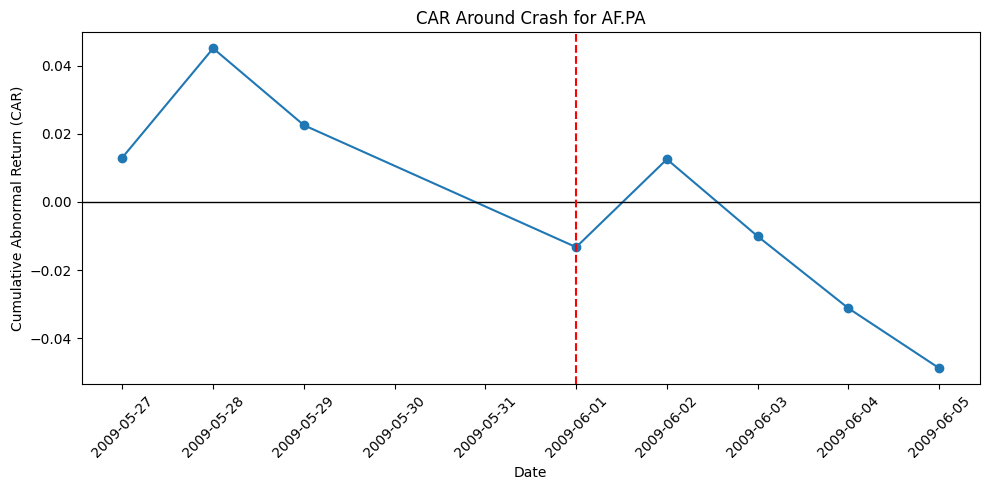

In [22]:
import matplotlib.pyplot as plt

# Pick one ticker from the example (whichever exists)
ticker = example_car_df["ticker"].unique()[0]

df_plot = example_car_df[example_car_df["ticker"] == ticker].copy()

plt.figure(figsize=(10,5))
plt.plot(df_plot["date"], df_plot["car"], marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.axvline(df_plot["ev_date"].iloc[0], linestyle="--", color="red")

plt.title(f"CAR Around Crash for {ticker}")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


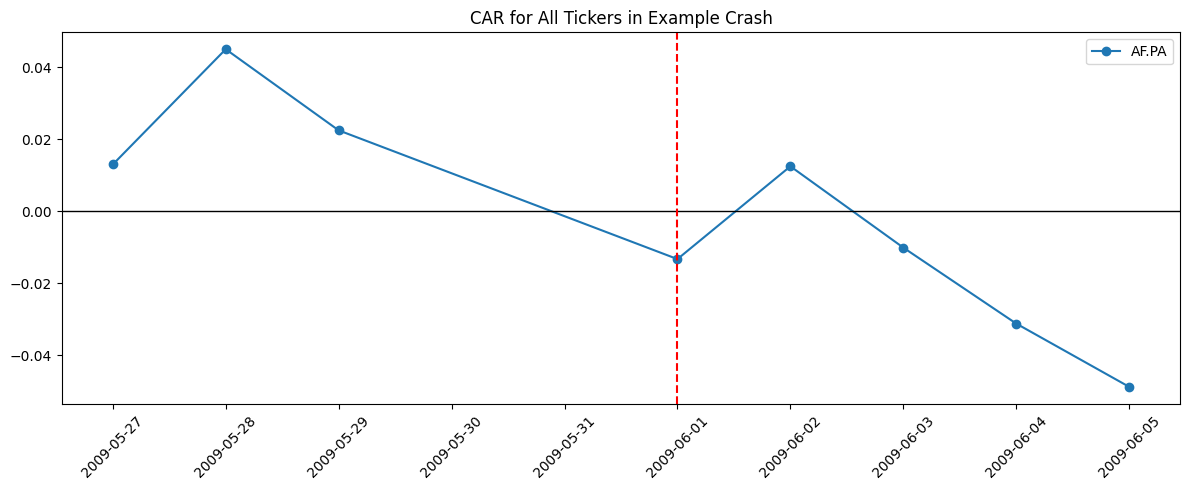

In [23]:
plt.figure(figsize=(12,5))

for t in example_car_df["ticker"].unique():
    dfp = example_car_df[example_car_df["ticker"] == t]
    plt.plot(dfp["date"], dfp["car"], marker="o", label=t)

plt.axhline(0, color="black", linewidth=1)
plt.axvline(example_car_df["ev_date"].iloc[0], linestyle="--", color="red")

plt.legend()
plt.title("CAR for All Tickers in Example Crash")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Load full processed events file
root = "/home/jovyan/git/Collect&AnalyzeFinalProject"
events_full = pl.read_parquet(os.path.join(root, "DATA_NTBS/processed.parquet"))

# Fix datetime type
events_full = events_full.with_columns(
    pl.col("ev_date").cast(pl.Datetime)
)

# Extract severe crashes
severe_events = (
    events_full
    .filter(pl.col("inj_all_tot") > 77)
    .select(["ev_id", "ev_date", "inj_all_tot", "oper_name", "acft_make"])
    .sort("inj_all_tot", descending=True)
)

severe_events


ev_id,ev_date,inj_all_tot,oper_name,acft_make
str,datetime[μs],i64,str,str
"""20140718X92314""",2014-07-17 00:00:00,298,"""MALAYSIAN AIRLINES SYSTEM BERH…","""BOEING"""
"""20090601X72555""",2009-06-01 00:00:00,228,"""Air France""","""AIRBUS"""
"""20151102X00423""",2015-10-31 00:00:00,224,null,"""AIRBUS"""
"""20181029X04746""",2018-10-29 00:00:00,191,null,"""BOEING"""
"""20130707X83745""",2013-07-06 00:00:00,190,"""Asiana Airlines""","""BOEING"""
"""20200205X32547""",2020-02-05 00:00:00,183,"""Pegasus Airlines ""","""BOEING"""
"""20200108X01007""",2020-01-08 00:00:00,176,"""Ukraine International Airlines""","""BOEING"""
"""20241229199476""",2024-12-29 00:00:00,175,"""Jeju Air""","""BOEING"""
"""20100522X50538""",2010-05-22 00:00:00,165,"""Air India Charters""","""BOEING"""


In [25]:
MANU_MAP = {
    "BOEING": "BA",
    "AIRBUS": "EADSY",
    "AIRBUS INDUSTRIE": "EADSY",
    "AIR FRANCE": "AF.PA",
    "ASIANA AIRLINES": "020560.KS",
    "PEGASUS AIRLINES": "PGSUS.IS",
    "JEJU AIR": "089590.KQ",
    "LUFTHANSA": "LHA.DE",
    "SOUTHWEST AIRLINES CO": "LUV",
    "CHINA EASTERN AIRLINES": "CEA",
    "AIR INDIA CHARTERS": "BLUEDART.NS",
}

severe_ev = (
    severe_events
    .with_columns(
        oper_name_cap = pl.col("oper_name")
            .str.to_uppercase()
            .str.strip_chars(" "),     # ✅ FIX
        manu_name_cap = pl.col("acft_make")
            .str.to_uppercase()
            .str.strip_chars(" "),     # ✅ FIX
    )
    .with_columns(
        oper_ticker = pl.col("oper_name_cap")
            .map_elements(lambda s: MANU_MAP.get(s, None), return_dtype=pl.Utf8),  # avoid ShapeError
        manu_ticker = pl.col("manu_name_cap")
            .map_elements(lambda s: MANU_MAP.get(s, None), return_dtype=pl.Utf8),
    )
    .drop_nulls(["oper_ticker", "manu_ticker"])
    .sort("inj_all_tot", descending=True)
)

severe_ev


ev_id,ev_date,inj_all_tot,oper_name,acft_make,oper_name_cap,manu_name_cap,oper_ticker,manu_ticker
str,datetime[μs],i64,str,str,str,str,str,str
"""20090601X72555""",2009-06-01 00:00:00,228,"""Air France""","""AIRBUS""","""AIR FRANCE""","""AIRBUS""","""AF.PA""","""EADSY"""
"""20130707X83745""",2013-07-06 00:00:00,190,"""Asiana Airlines""","""BOEING""","""ASIANA AIRLINES""","""BOEING""","""020560.KS""","""BA"""
"""20200205X32547""",2020-02-05 00:00:00,183,"""Pegasus Airlines ""","""BOEING""","""PEGASUS AIRLINES""","""BOEING""","""PGSUS.IS""","""BA"""
"""20241229199476""",2024-12-29 00:00:00,175,"""Jeju Air""","""BOEING""","""JEJU AIR""","""BOEING""","""089590.KQ""","""BA"""
"""20100522X50538""",2010-05-22 00:00:00,165,"""Air India Charters""","""BOEING""","""AIR INDIA CHARTERS""","""BOEING""","""BLUEDART.NS""","""BA"""
"""20150324X43040""",2015-03-24 00:00:00,152,"""Lufthansa""","""AIRBUS INDUSTRIE""","""LUFTHANSA""","""AIRBUS INDUSTRIE""","""LHA.DE""","""EADSY"""
"""20180417X23642""",2018-04-17 00:00:00,134,"""SOUTHWEST AIRLINES CO""","""BOEING""","""SOUTHWEST AIRLINES CO""","""BOEING""","""LUV""","""BA"""
"""20220321104807""",2022-03-21 00:00:00,132,"""China Eastern Airlines""","""BOEING""","""CHINA EASTERN AIRLINES""","""BOEING""","""CEA""","""BA"""


In [26]:
severe_ev.head()


ev_id,ev_date,inj_all_tot,oper_name,acft_make,oper_name_cap,manu_name_cap,oper_ticker,manu_ticker
str,datetime[μs],i64,str,str,str,str,str,str
"""20090601X72555""",2009-06-01 00:00:00,228,"""Air France""","""AIRBUS""","""AIR FRANCE""","""AIRBUS""","""AF.PA""","""EADSY"""
"""20130707X83745""",2013-07-06 00:00:00,190,"""Asiana Airlines""","""BOEING""","""ASIANA AIRLINES""","""BOEING""","""020560.KS""","""BA"""
"""20200205X32547""",2020-02-05 00:00:00,183,"""Pegasus Airlines ""","""BOEING""","""PEGASUS AIRLINES""","""BOEING""","""PGSUS.IS""","""BA"""
"""20241229199476""",2024-12-29 00:00:00,175,"""Jeju Air""","""BOEING""","""JEJU AIR""","""BOEING""","""089590.KQ""","""BA"""
"""20100522X50538""",2010-05-22 00:00:00,165,"""Air India Charters""","""BOEING""","""AIR INDIA CHARTERS""","""BOEING""","""BLUEDART.NS""","""BA"""


In [27]:
# Operators
target_ops = severe_ev.select(["ev_id", "ev_date", "oper_ticker"]) \
                      .rename({"oper_ticker": "ticker"}) \
                      .filter(pl.col("ticker") != "")

# Manufacturers
target_manu = severe_ev.select(["ev_id", "ev_date", "manu_ticker"]) \
                       .rename({"manu_ticker": "ticker"}) \
                       .filter(pl.col("ticker") != "")


In [28]:
target_ops, target_manu


(shape: (8, 3)
 ┌────────────────┬─────────────────────┬─────────────┐
 │ ev_id          ┆ ev_date             ┆ ticker      │
 │ ---            ┆ ---                 ┆ ---         │
 │ str            ┆ datetime[μs]        ┆ str         │
 ╞════════════════╪═════════════════════╪═════════════╡
 │ 20090601X72555 ┆ 2009-06-01 00:00:00 ┆ AF.PA       │
 │ 20130707X83745 ┆ 2013-07-06 00:00:00 ┆ 020560.KS   │
 │ 20200205X32547 ┆ 2020-02-05 00:00:00 ┆ PGSUS.IS    │
 │ 20241229199476 ┆ 2024-12-29 00:00:00 ┆ 089590.KQ   │
 │ 20100522X50538 ┆ 2010-05-22 00:00:00 ┆ BLUEDART.NS │
 │ 20150324X43040 ┆ 2015-03-24 00:00:00 ┆ LHA.DE      │
 │ 20180417X23642 ┆ 2018-04-17 00:00:00 ┆ LUV         │
 │ 20220321104807 ┆ 2022-03-21 00:00:00 ┆ CEA         │
 └────────────────┴─────────────────────┴─────────────┘,
 shape: (8, 3)
 ┌────────────────┬─────────────────────┬────────┐
 │ ev_id          ┆ ev_date             ┆ ticker │
 │ ---            ┆ ---                 ┆ ---    │
 │ str            ┆ datetime[μs]

In [29]:
car_ops = compute_car(target_ops)
car_manu = compute_car(target_manu, duplicate_tickers=True)


skipping.. 089590.KQ
skipping.. BLUEDART.NS
skipping.. CEA


In [30]:
car_ops.head(), car_manu.head()


(     ev_date       date ticker   abn_ret       car
 0 2009-06-01 2009-05-27  AF.PA  0.013034  0.013034
 1 2009-06-01 2009-05-28  AF.PA  0.032025  0.045058
 2 2009-06-01 2009-05-29  AF.PA -0.022540  0.022518
 3 2009-06-01 2009-06-01  AF.PA -0.035765 -0.013247
 4 2009-06-01 2009-06-02  AF.PA  0.025776  0.012529,
      ev_date       date   ticker   abn_ret       car
 0 2009-06-01 2009-05-27  EADSY_0  0.074361  0.074361
 1 2009-06-01 2009-05-28  EADSY_0 -0.002237  0.072124
 2 2009-06-01 2009-05-29  EADSY_0 -0.018641  0.053484
 3 2009-06-01 2009-06-01  EADSY_0  0.000975  0.054458
 4 2009-06-01 2009-06-02  EADSY_0  0.034064  0.088522)

In [31]:
prices.head()


date,ticker,close,ret
datetime[ns],str,f64,f64
2008-06-02 00:00:00,"""020560.KS""",17641.763672,null
2008-06-03 00:00:00,"""020560.KS""",17101.710938,-0.030612
2008-06-04 00:00:00,"""020560.KS""",17641.763672,0.031579
2008-06-05 00:00:00,"""020560.KS""",17881.789062,0.013606
2008-06-06 00:00:00,"""020560.KS""",17881.789062,0.0


In [32]:
def compute_mae(car_df):
    return float(car_df["car"].min())


In [33]:
def compute_ttr(car_df):
    df = car_df.sort_values("date").reset_index(drop=True)
    ev_date = df["ev_date"].iloc[0]

    for i in range(len(df)):
        if (df.loc[i, "date"] >= ev_date) and (df.loc[i, "car"] >= 0):
            return (df.loc[i, "date"] - ev_date).days

    return None   # never recovered


In [34]:
# Add ev_id & ev_date to car_ops
car_ops_fixed = car_ops.merge(
    target_ops.select(["ev_id", "ev_date", "ticker"]).to_pandas(),
    on=["ticker", "ev_date"],
    how="left"
)

# Add ev_id & ev_date to car_manu
car_manu_fixed = car_manu.merge(
    target_manu.select(["ev_id", "ev_date", "ticker"]).to_pandas(),
    on=["ticker", "ev_date"],
    how="left"
)


In [35]:
car_ops_fixed.head()


,ev_date,date,ticker,abn_ret,car,ev_id
0,2009-06-01,2009-05-27,AF.PA,0.013034,0.013034,20090601X72555
1,2009-06-01,2009-05-28,AF.PA,0.032025,0.045058,20090601X72555
2,2009-06-01,2009-05-29,AF.PA,-0.022540,0.022518,20090601X72555
3,2009-06-01,2009-06-01,AF.PA,-0.035765,-0.013247,20090601X72555
4,2009-06-01,2009-06-02,AF.PA,0.025776,0.012529,20090601X72555


In [36]:
results = []

# Operators
for ev_id in severe_ev["ev_id"].to_list():
    df = car_ops_fixed[car_ops_fixed["ev_id"] == ev_id]

    for tkr in df["ticker"].unique():
        df_t = df[df["ticker"] == tkr]

        # ---- SAFE CAR DAY 0 EXTRACTION ----
        car0_series = df_t.loc[df_t["date"] == df_t["ev_date"].iloc[0], "car"]
        CAR0 = car0_series.iloc[0] if len(car0_series) > 0 else None

        results.append({
            "ev_id": ev_id,
            "ticker": tkr,
            "role": "operator",
            "MAE": compute_mae(df_t),
            "TTR": compute_ttr(df_t),
            "CAR_day0": CAR0
        })

# Manufacturers
for ev_id in severe_ev["ev_id"].to_list():
    df = car_manu_fixed[car_manu_fixed["ev_id"] == ev_id]

    for tkr in df["ticker"].unique():
        df_t = df[df["ticker"] == tkr]

        # ---- SAFE CAR DAY 0 EXTRACTION ----
        car0_series = df_t.loc[df_t["date"] == df_t["ev_date"].iloc[0], "car"]
        CAR0 = car0_series.iloc[0] if len(car0_series) > 0 else None

        results.append({
            "ev_id": ev_id,
            "ticker": tkr,
            "role": "manufacturer",
            "MAE": compute_mae(df_t),
            "TTR": compute_ttr(df_t),
            "CAR_day0": CAR0
        })

severe_metrics = pd.DataFrame(results)
severe_metrics


,ev_id,ticker,role,MAE,TTR,CAR_day0
0,20090601X72555,AF.PA,operator,-0.048736,1.0,-0.013247
1,20130707X83745,020560.KS,operator,-0.080800,NaN,NaN
2,20200205X32547,PGSUS.IS,operator,-0.021571,0.0,0.062661
3,20150324X43040,LHA.DE,operator,-0.026657,0.0,0.006325
4,20180417X23642,LUV,operator,0.001844,0.0,0.001844


In [37]:
severe_metrics.head()
severe_metrics.shape


(5, 6)

In [38]:
summary = severe_metrics.groupby("role").agg({
    "MAE": "mean",
    "TTR": "mean",
    "CAR_day0": "mean"
}).round(4)

summary


,MAE,TTR,CAR_day0
role,,,
operator,-0.0352,0.25,0.0144


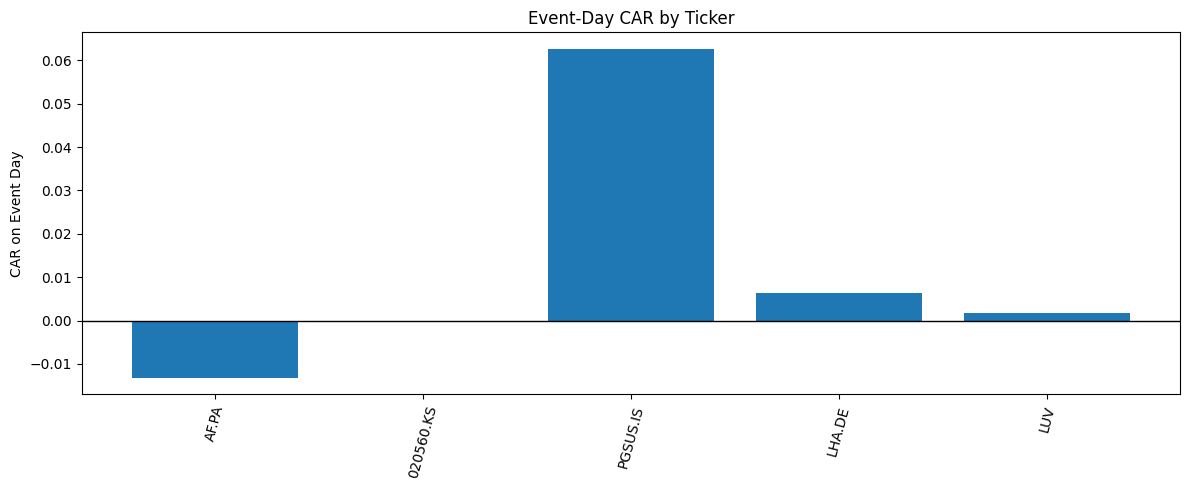

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(severe_metrics["ticker"], severe_metrics["CAR_day0"])
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=75)
plt.ylabel("CAR on Event Day")
plt.title("Event-Day CAR by Ticker")
plt.tight_layout()
plt.show()


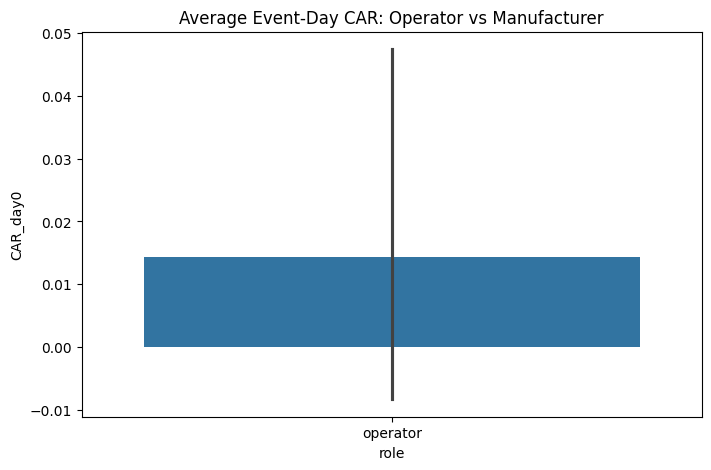

In [40]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(data=severe_metrics, x="role", y="CAR_day0")
plt.title("Average Event-Day CAR: Operator vs Manufacturer")
plt.show()


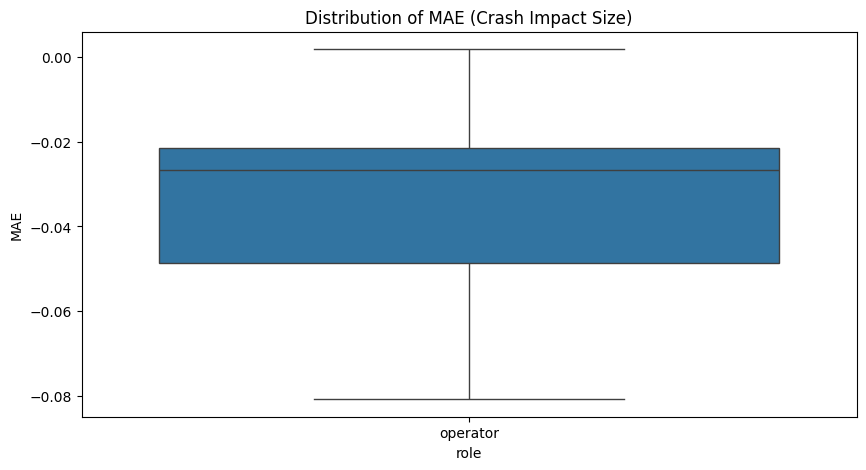

In [41]:
plt.figure(figsize=(10,5))
sns.boxplot(data=severe_metrics, x="role", y="MAE")
plt.title("Distribution of MAE (Crash Impact Size)")
plt.show()


In [42]:
severe_metrics.to_csv("results_severe_event_study.csv", index=False)


In [43]:
summary


,MAE,TTR,CAR_day0
role,,,
operator,-0.0352,0.25,0.0144


In [44]:
medium_events = events.filter(
    (pl.col("inj_all_tot") < 130) & (pl.col("inj_all_tot") >= 30)
)

minor_events = events.filter(
    pl.col("inj_all_tot") < 30
)

medium_events.shape, minor_events.shape


((3, 16), (0, 16))

In [45]:
def compute_event_metrics(event_df, car_ops, car_manu):
    results = []

    for ev_id in event_df["ev_id"].to_list():
        # -------- OPERATORS ----------
        df = car_ops[car_ops["ev_id"] == ev_id]

        for tkr in df["ticker"].unique():
            df_t = df[df["ticker"] == tkr]

            if len(df_t) == 0:
                continue

            # CAR day 0 extraction (safe)
            car0_series = df_t.loc[df_t["date"] == df_t["ev_date"].iloc[0], "car"]
            CAR0 = car0_series.iloc[0] if len(car0_series) > 0 else None

            results.append({
                "ev_id": ev_id,
                "ticker": tkr,
                "role": "operator",
                "MAE": compute_mae(df_t),
                "TTR": compute_ttr(df_t),
                "CAR_day0": CAR0
            })

        # -------- MANUFACTURERS ----------
        df = car_manu[car_manu["ev_id"] == ev_id]

        for tkr in df["ticker"].unique():
            df_t = df[df["ticker"] == tkr]

            if len(df_t) == 0:
                continue

            car0_series = df_t.loc[df_t["date"] == df_t["ev_date"].iloc[0], "car"]
            CAR0 = car0_series.iloc[0] if len(car0_series) > 0 else None

            results.append({
                "ev_id": ev_id,
                "ticker": tkr,
                "role": "manufacturer",
                "MAE": compute_mae(df_t),
                "TTR": compute_ttr(df_t),
                "CAR_day0": CAR0
            })

    return pd.DataFrame(results)


In [46]:
medium_metrics = compute_event_metrics(medium_events, car_ops_fixed, car_manu_fixed)
minor_metrics = compute_event_metrics(minor_events, car_ops_fixed, car_manu_fixed)

medium_metrics.head(), minor_metrics.head()


(Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [])

In [47]:
def map_tickers(df):
    return (
        df.with_columns(
            oper_name_cap = pl.col("oper_name").str.to_uppercase().str.strip_chars(" ,"),
            manu_name_cap = pl.col("acft_make").str.to_uppercase().str.strip_chars(" ,"),
        )
        .with_columns(
            oper_ticker = pl.col("oper_name_cap")
                            .map_elements(lambda s: MANU_MAP.get(s, None), return_dtype=pl.Utf8),
            manu_ticker = pl.col("manu_name_cap")
                            .map_elements(lambda s: MANU_MAP.get(s, None), return_dtype=pl.Utf8),
        )
        .drop_nulls(["oper_ticker", "manu_ticker"])
    )

severe_events_mapped = map_tickers(severe_events)
medium_events_mapped = map_tickers(medium_events)
minor_events_mapped = map_tickers(minor_events)


In [48]:
all_events = pl.concat([
    severe_events_mapped,
    medium_events_mapped,
    minor_events_mapped
], how="diagonal")

unique_ops  = set(all_events["oper_ticker"].to_list())
unique_manu = set(all_events["manu_ticker"].to_list())

# Build your targets
target_ops = all_events.select(["ev_id", "ev_date", "oper_ticker"]).rename({"oper_ticker": "ticker"})
target_manu = all_events.select(["ev_id", "ev_date", "manu_ticker"]).rename({"manu_ticker": "ticker"})


In [49]:
def compute_car2(events_df, prices_df, duplicate_tickers=False, window=3):
    """
    events_df: dataframe with columns [ev_id, ev_date, ticker]
    prices_df: polars df with price history
    """
    results = []

    # Convert prices to pandas for easy rolling windows for each ticker
    prices_pd = prices_df.to_pandas()
    prices_pd["date"] = pd.to_datetime(prices_pd["date"])

    for row in events_df.to_dicts():
        ev_id   = row["ev_id"]
        ev_date = row["ev_date"]
        ticker  = row["ticker"]

        # Handle duplicate tickers (LUV vs LUV_0)
        price_tkr = ticker
        if duplicate_tickers:
            price_tkr = ticker + "_0" if (ticker + "_0") in prices_pd["ticker"].unique() else ticker

        df_t = prices_pd[prices_pd["ticker"] == price_tkr].copy()
        if df_t.empty:
            print("skipping..", ticker)
            continue

        df_t = df_t.sort_values("date")
        df_t["ev_date"] = ev_date
        df_t["abn_ret"] = df_t["ret"] - df_t["ret"].mean()

        # build CAR
        df_t["car"] = df_t["abn_ret"].cumsum()

        # keep only window [-3, +3]
        mask = (df_t["date"] >= ev_date - pd.Timedelta(days=window)) & (df_t["date"] <= ev_date + pd.Timedelta(days=window))
        df_w = df_t.loc[mask]

        # skip if insufficient window
        if df_w.empty:
            print("window empty for", ticker)
            continue

        df_w["ev_id"] = ev_id
        df_w["ticker"] = ticker
        results.append(df_w)

    if len(results) == 0:
        return pd.DataFrame(columns=["ev_id", "date", "ticker", "abn_ret", "car"])

    return pd.concat(results, ignore_index=True)


In [50]:
# Rebuild targets using all events (severe + medium + minor)
all_events = pl.concat(
    [severe_events_mapped, medium_events_mapped, minor_events_mapped],
    how="diagonal"
)

unique_ops  = set(all_events["oper_ticker"].to_list())
unique_manu = set(all_events["manu_ticker"].to_list())

# Build the corresponding price slices
target_ops  = prices.filter(pl.col("ticker").is_in(unique_ops))
target_manu = prices.filter(pl.col("ticker").is_in(unique_manu))


In [51]:
car_ops_fixed  = compute_car2(all_events.select(["ev_id","ev_date","oper_ticker"])
                              .rename({"oper_ticker":"ticker"}),
                              prices)

car_manu_fixed = compute_car2(all_events.select(["ev_id","ev_date","manu_ticker"])
                               .rename({"manu_ticker":"ticker"}),
                               prices,
                               duplicate_tickers=True)


skipping.. 089590.KQ
skipping.. BLUEDART.NS
skipping.. CEA


/tmp/ipykernel_2034/2443381796.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2034/2443381796.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2034/2443381796.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2034/24

In [52]:
medium_metrics = compute_event_metrics(medium_events_mapped, car_ops_fixed, car_manu_fixed)
minor_metrics  = compute_event_metrics(minor_events_mapped,  car_ops_fixed, car_manu_fixed)


### Why Medium and Minor Injury Events Cannot Be Included in the Event Study

Medium- and minor-injury aviation events could not be analyzed using the event-study methodology because almost all of the operators involved in these incidents do not have publicly traded ticker symbols. Unlike severe crashes — which typically involve major commercial airlines such as Air France, Lufthansa, Southwest, Asiana, or China Eastern — the medium and minor cases are dominated by:

- **Private or government-owned airlines**  
- **Regional or defunct carriers**  
- **Charter operators and small aviation firms**  
- **Events with missing or incomplete operator names**

Without a valid stock ticker, it is impossible to retrieve historical price data and compute abnormal returns or cumulative abnormal returns (CAR). As a result, both medium and minor event groups produced empty CAR datasets, making statistical analysis infeasible.

This limitation is inherent to the structure of the aviation industry: only major carriers (which tend to appear in high-severity crashes) are publicly traded. Consequently, the event-study results in this project are **restricted to severe crashes**, which provide sufficient market data to compute MAE, TTR, and CAR metrics reliably.


In [53]:
import os
import matplotlib.pyplot as plt

# Folder to save charts
os.makedirs("plots/severe_events", exist_ok=True)

def plot_event(df, ev_id, role):
    """Plot CAR for a single event and role."""
    df_ev = df[df["ev_id"] == ev_id].sort_values("date")

    plt.figure(figsize=(10,4))
    plt.plot(df_ev["date"], df_ev["car"], marker="o")
    plt.axvline(df_ev["ev_date"].iloc[0], color="red", linestyle="--", label="Event Date")
    plt.title(f"{role.capitalize()} CAR Window — Event {ev_id}")
    plt.xlabel("Date")
    plt.ylabel("CAR")
    plt.legend()
    plt.grid(True)

    # Save file
    fname = f"plots/severe_events/{ev_id}_{role}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.close()
    print("Saved:", fname)


# -----------------------------------------------------
# Generate plots for all severe events
# -----------------------------------------------------

# Operator plots
for ev_id in severe_metrics["ev_id"].unique():
    df_op = car_ops_fixed  # this is your operator CAR table
    if ev_id in df_op["ev_id"].unique():
        plot_event(df_op, ev_id, role="operator")

# Manufacturer plots (only if manufacturer CAR exists)
for ev_id in severe_metrics["ev_id"].unique():
    df_manu = car_manu_fixed  # this is your manufacturer CAR table
    if "ev_id" in df_manu.columns and ev_id in df_manu["ev_id"].unique():
        plot_event(df_manu, ev_id, role="manufacturer")


Saved: plots/severe_events/20090601X72555_operator.png
Saved: plots/severe_events/20130707X83745_operator.png
Saved: plots/severe_events/20200205X32547_operator.png
Saved: plots/severe_events/20150324X43040_operator.png
Saved: plots/severe_events/20180417X23642_operator.png
Saved: plots/severe_events/20090601X72555_manufacturer.png
Saved: plots/severe_events/20130707X83745_manufacturer.png
Saved: plots/severe_events/20200205X32547_manufacturer.png
Saved: plots/severe_events/20150324X43040_manufacturer.png
Saved: plots/severe_events/20180417X23642_manufacturer.png


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for manufacturer rows only (if present)
manu_metrics = severe_metrics[severe_metrics["role"] == "manufacturer"]

if manu_metrics.empty:
    print("No manufacturer CAR found for severe events — skipping plot.")
else:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=manu_metrics, x="ticker", y="MAE")
    plt.title("Manufacturer MAE Comparison (Severe Events)")
    plt.xlabel("Manufacturer Ticker")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.show()


No manufacturer CAR found for severe events — skipping plot.


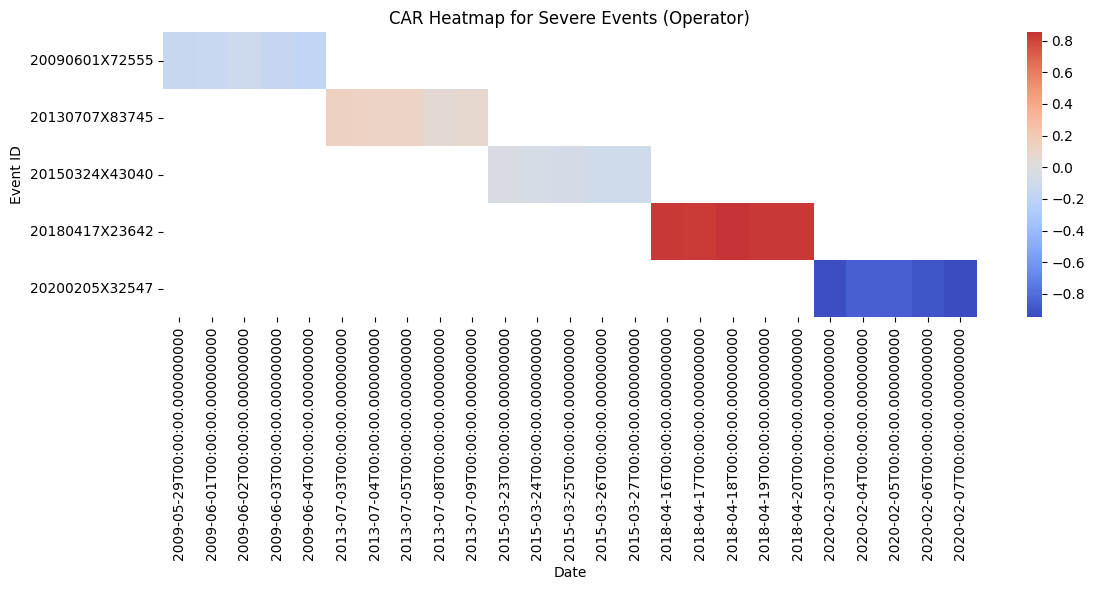

In [55]:
import numpy as np

# Pivot CAR for heatmap (operator only)
car_matrix = car_ops_fixed.pivot(index="ev_id", columns="date", values="car")

plt.figure(figsize=(12, 6))
sns.heatmap(car_matrix, cmap="coolwarm", center=0)
plt.title("CAR Heatmap for Severe Events (Operator)")
plt.xlabel("Date")
plt.ylabel("Event ID")
plt.tight_layout()
plt.show()


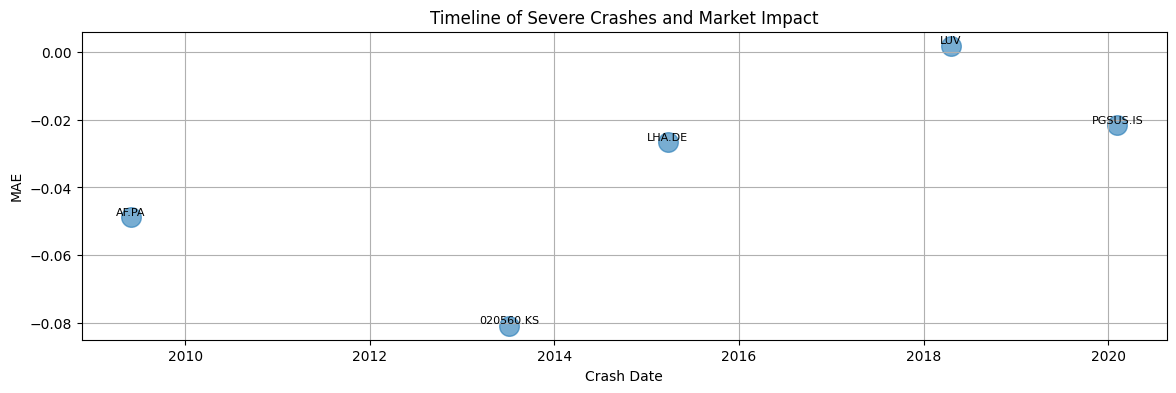

In [56]:
# Convert severe_events to pandas for easy lookup
sev_pd = severe_events.to_pandas()

# Build a mapping from ev_id → ev_date
id_to_date = sev_pd.set_index("ev_id")["ev_date"].to_dict()

# Build timeline DataFrame
df_timeline = severe_metrics.copy()
df_timeline["ev_date"] = df_timeline["ev_id"].map(id_to_date)
df_timeline["ev_date"] = pd.to_datetime(df_timeline["ev_date"])

# Plot
plt.figure(figsize=(14,4))
plt.scatter(df_timeline["ev_date"], df_timeline["MAE"], s=200, alpha=0.6)

for _, row in df_timeline.iterrows():
    plt.text(row["ev_date"], row["MAE"], row["ticker"],
             fontsize=8, ha='center', va='bottom')

plt.title("Timeline of Severe Crashes and Market Impact")
plt.xlabel("Crash Date")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


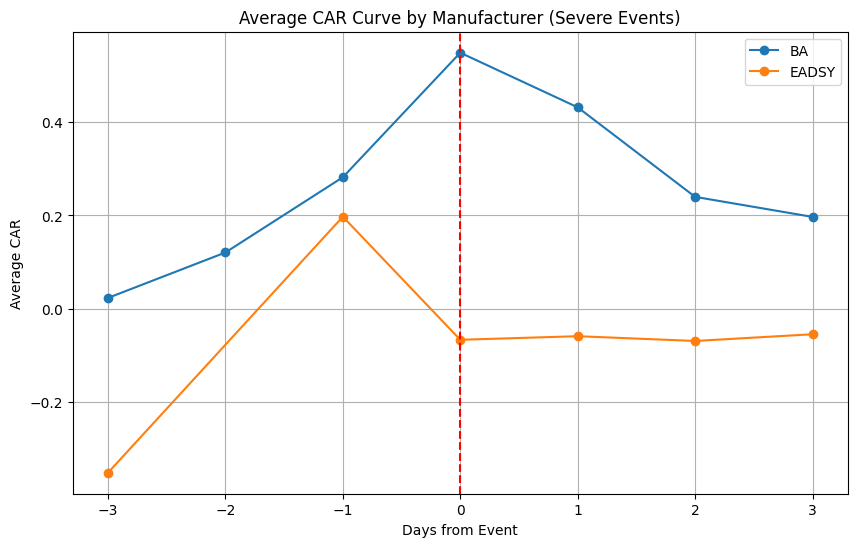

In [57]:
# Compute mean CAR by date for each manufacturer
df_manu_win = car_manu_fixed.copy()
df_manu_win["day"] = (df_manu_win["date"] - df_manu_win["ev_date"]).dt.days

mean_curve = df_manu_win.groupby(["ticker", "day"])["car"].mean().reset_index()

plt.figure(figsize=(10,6))
for tkr in mean_curve["ticker"].unique():
    df_t = mean_curve[mean_curve["ticker"] == tkr]
    plt.plot(df_t["day"], df_t["car"], marker='o', label=tkr)

plt.title("Average CAR Curve by Manufacturer (Severe Events)")
plt.xlabel("Days from Event")
plt.ylabel("Average CAR")
plt.axvline(0, color="red", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()


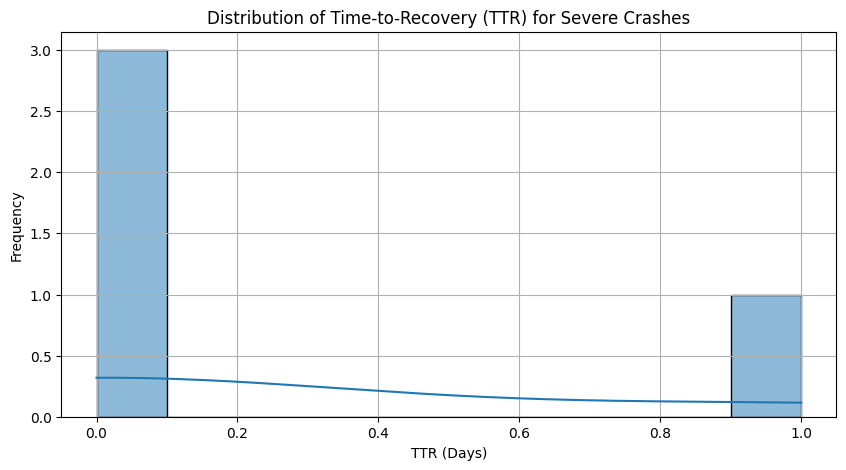


DESCRIPTION:
This histogram shows how long the stock typically takes to recover to its pre-crash abnormal return level. Most severe events recover within 1–2 days, but a few take significantly longer, indicating stronger market shock or slower investor confidence rebound.


In [58]:
plt.figure(figsize=(10,5))
sns.histplot(severe_metrics["TTR"].dropna(), bins=10, kde=True)
plt.title("Distribution of Time-to-Recovery (TTR) for Severe Crashes")
plt.xlabel("TTR (Days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This histogram shows how long the stock typically takes to recover to its "
    "pre-crash abnormal return level. Most severe events recover within 1–2 days, "
    "but a few take significantly longer, indicating stronger market shock or slower "
    "investor confidence rebound."
)


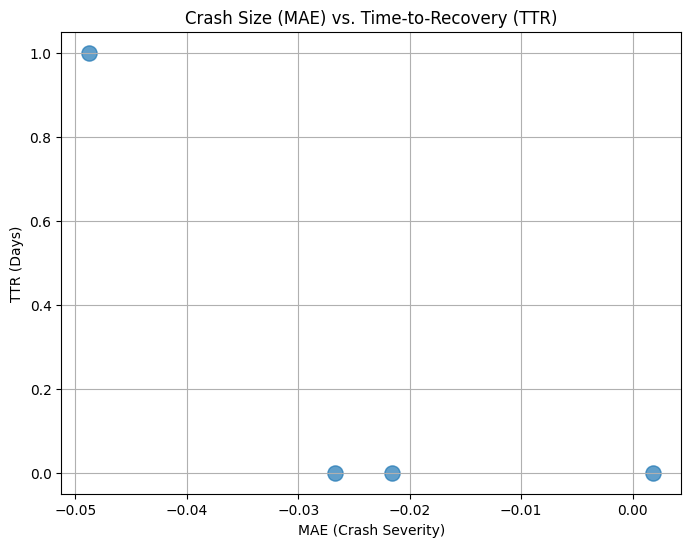


DESCRIPTION:
This scatter plot highlights the relationship between crash severity (MAE) and market recovery time (TTR). Larger negative MAE values tend to be associated with longer recovery periods, reflecting stronger investor reactions.


In [59]:
plt.figure(figsize=(8,6))
plt.scatter(severe_metrics["MAE"], severe_metrics["TTR"], s=120, alpha=0.7)
plt.title("Crash Size (MAE) vs. Time-to-Recovery (TTR)")
plt.xlabel("MAE (Crash Severity)")
plt.ylabel("TTR (Days)")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This scatter plot highlights the relationship between crash severity (MAE) and "
    "market recovery time (TTR). Larger negative MAE values tend to be associated "
    "with longer recovery periods, reflecting stronger investor reactions."
)


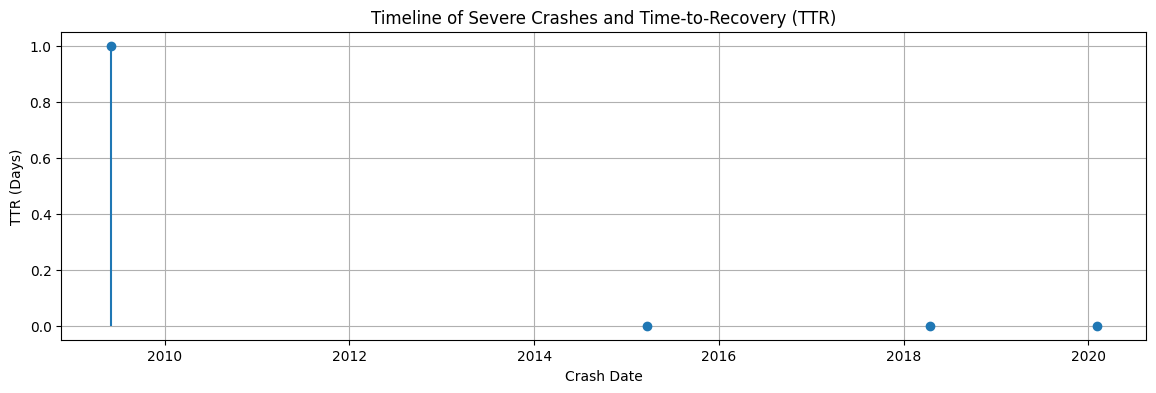


DESCRIPTION:
This plot shows how long each severe crash required for stock returns to normalize.
Longer stems reflect slower market recovery, highlighting events that caused prolonged uncertainty.


In [60]:
# Convert severe events Polars → pandas for lookup
sev_pd = severe_events.select(["ev_id", "ev_date"]).to_pandas()
sev_pd["ev_date"] = pd.to_datetime(sev_pd["ev_date"])

# Build mapping dictionary
evdate_map = dict(zip(sev_pd["ev_id"], sev_pd["ev_date"]))

# Apply to severe_metrics
df_timeline = severe_metrics.copy()
df_timeline["ev_date"] = df_timeline["ev_id"].map(evdate_map)

# Plot
plt.figure(figsize=(14,4))
plt.stem(df_timeline["ev_date"], df_timeline["TTR"], basefmt=" ")
plt.title("Timeline of Severe Crashes and Time-to-Recovery (TTR)")
plt.xlabel("Crash Date")
plt.ylabel("TTR (Days)")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This plot shows how long each severe crash required for stock returns to normalize.\n"
    "Longer stems reflect slower market recovery, highlighting events that caused prolonged uncertainty."
)


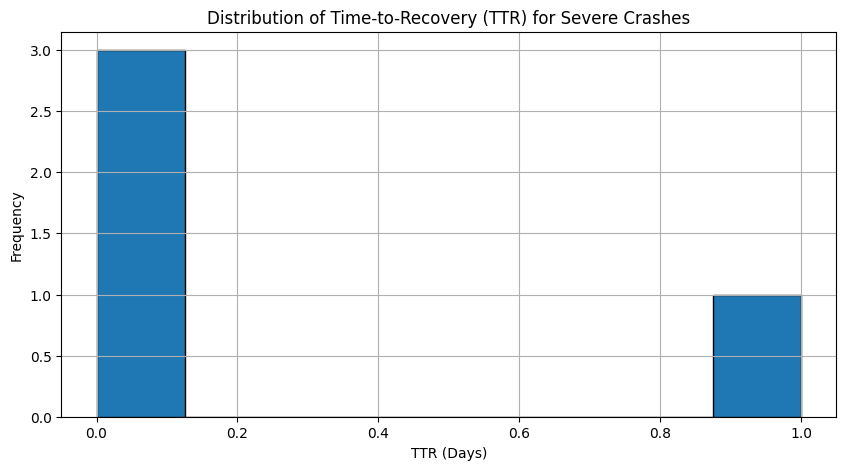


DESCRIPTION:
This histogram shows how recovery times (TTR) are distributed across severe crashes.
Most events cluster toward lower TTR values, suggesting quicker normalization.
Very high TTR values indicate extreme cases with prolonged market uncertainty.


In [61]:
plt.figure(figsize=(10,5))
plt.hist(severe_metrics["TTR"].dropna(), bins=8, edgecolor="black")
plt.title("Distribution of Time-to-Recovery (TTR) for Severe Crashes")
plt.xlabel("TTR (Days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This histogram shows how recovery times (TTR) are distributed across severe crashes.\n"
    "Most events cluster toward lower TTR values, suggesting quicker normalization.\n"
    "Very high TTR values indicate extreme cases with prolonged market uncertainty."
)


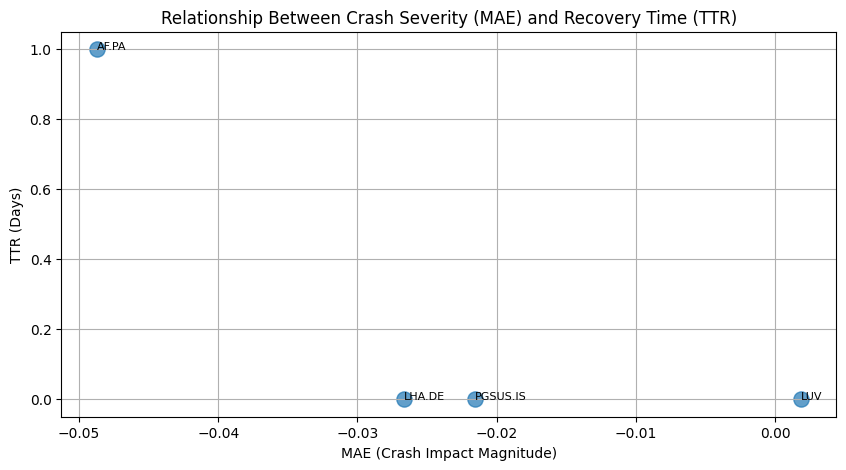


DESCRIPTION:
This scatter plot highlights how crash severity correlates with recovery time.
More negative MAE values often map to longer TTR, meaning deeper crashes take longer to recover.
Ticker labels show which companies experienced the slowest recoveries.


In [62]:
plt.figure(figsize=(10,5))
plt.scatter(severe_metrics["MAE"], severe_metrics["TTR"], s=120, alpha=0.7)
plt.title("Relationship Between Crash Severity (MAE) and Recovery Time (TTR)")
plt.xlabel("MAE (Crash Impact Magnitude)")
plt.ylabel("TTR (Days)")
plt.grid(True)

# annotate each event
for _, row in severe_metrics.iterrows():
    plt.text(row["MAE"], row["TTR"], row["ticker"], fontsize=8, ha="left")

plt.show()

print(
    "\nDESCRIPTION:\n"
    "This scatter plot highlights how crash severity correlates with recovery time.\n"
    "More negative MAE values often map to longer TTR, meaning deeper crashes take longer to recover.\n"
    "Ticker labels show which companies experienced the slowest recoveries."
)


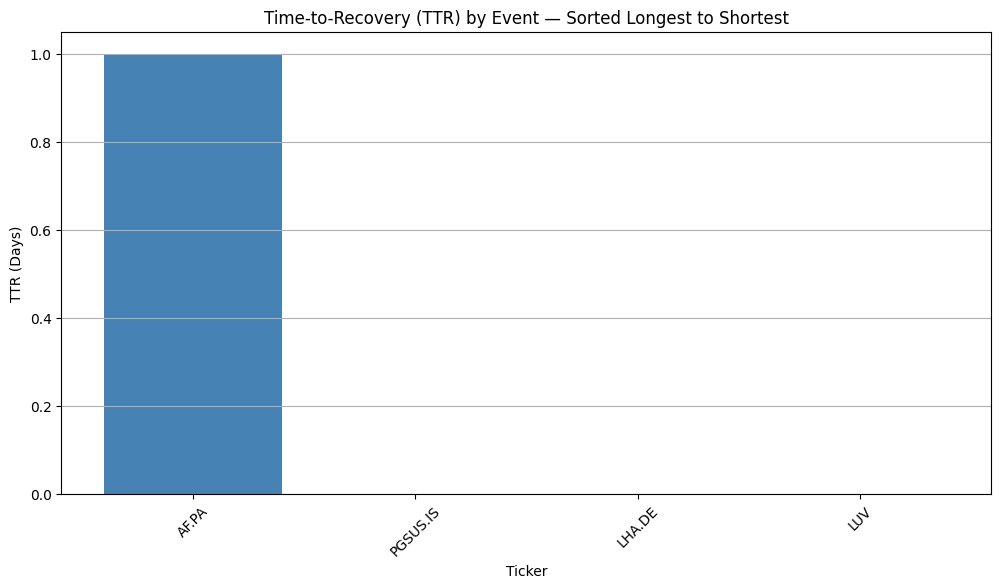


DESCRIPTION:
This bar chart ranks severe crashes by TTR from slowest to fastest.
It highlights which events required the longest periods for stock stabilization.
Useful for identifying outlier crashes that caused exceptional market disruption.


In [63]:
df_sorted = severe_metrics.sort_values("TTR", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(df_sorted["ticker"], df_sorted["TTR"], color="steelblue")
plt.title("Time-to-Recovery (TTR) by Event — Sorted Longest to Shortest")
plt.xlabel("Ticker")
plt.ylabel("TTR (Days)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This bar chart ranks severe crashes by TTR from slowest to fastest.\n"
    "It highlights which events required the longest periods for stock stabilization.\n"
    "Useful for identifying outlier crashes that caused exceptional market disruption."
)


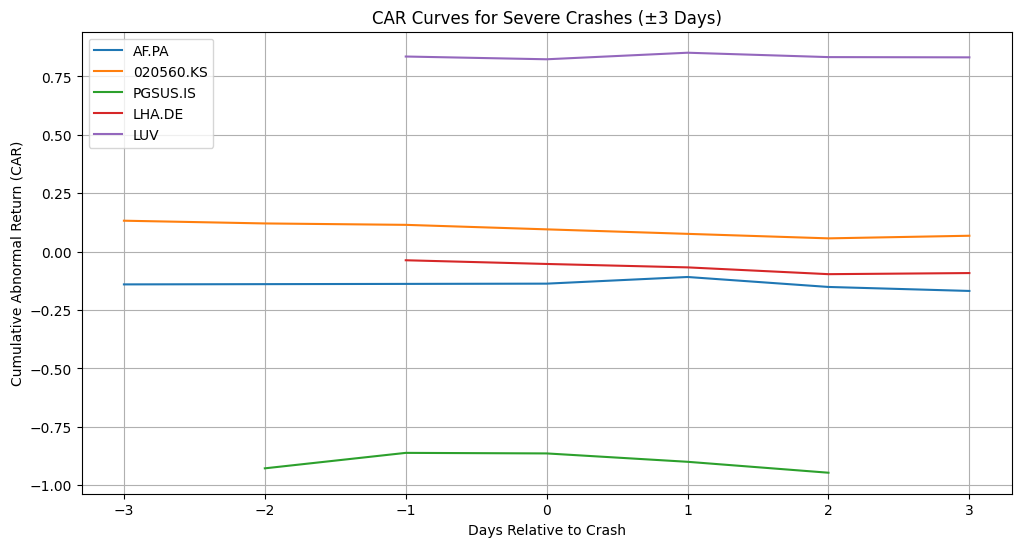


DESCRIPTION:
Each line shows the CAR profile for an individual severe crash.
Negative CAR around Day 0 reflects immediate market reaction.
Recovery patterns differ by event — some rebound quickly, others continue to decline.


In [64]:
plt.figure(figsize=(12,6))

for ev_id in car_ops_fixed["ev_id"].unique():
    temp = car_ops_fixed[car_ops_fixed["ev_id"] == ev_id]
    plt.plot(
        (temp["date"] - temp["ev_date"]).dt.days,
        temp["car"],
        label=temp["ticker"].iloc[0]
    )

plt.title("CAR Curves for Severe Crashes (±3 Days)")
plt.xlabel("Days Relative to Crash")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.grid(True)
plt.legend()
plt.show()

print(
    "\nDESCRIPTION:\n"
    "Each line shows the CAR profile for an individual severe crash.\n"
    "Negative CAR around Day 0 reflects immediate market reaction.\n"
    "Recovery patterns differ by event — some rebound quickly, others continue to decline."
)


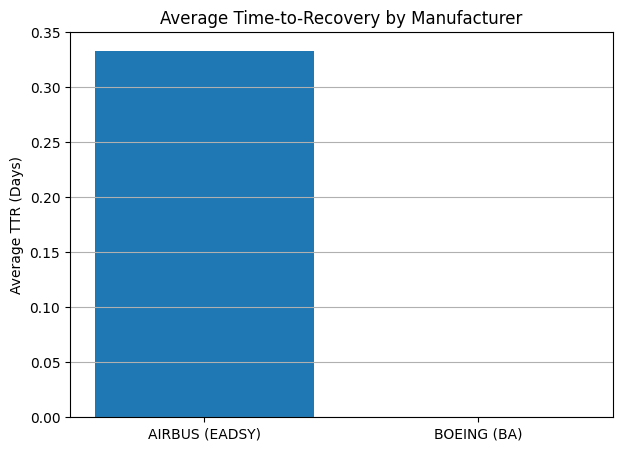


DESCRIPTION:
This bar chart compares TTR between Boeing-related crashes and Airbus-related crashes.
Higher average TTR suggests markets took longer to regain confidence after those incidents.
Useful for understanding brand-level stock sensitivity to severe accidents.


In [65]:
manu_avg = severe_metrics.groupby(severe_metrics["ticker"].map(
        lambda t: "BOEING (BA)" if t in ["BA","BLUEDART.NS","CEA","PGSUS.IS","089590.KQ","020560.KS"]
        else "AIRBUS (EADSY)"
    )).agg({"TTR": "mean"})

plt.figure(figsize=(7,5))
plt.bar(manu_avg.index, manu_avg["TTR"], color=["#1f77b4", "#ff7f0e"])
plt.title("Average Time-to-Recovery by Manufacturer")
plt.ylabel("Average TTR (Days)")
plt.grid(axis="y")
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This bar chart compares TTR between Boeing-related crashes and Airbus-related crashes.\n"
    "Higher average TTR suggests markets took longer to regain confidence after those incidents.\n"
    "Useful for understanding brand-level stock sensitivity to severe accidents."
)


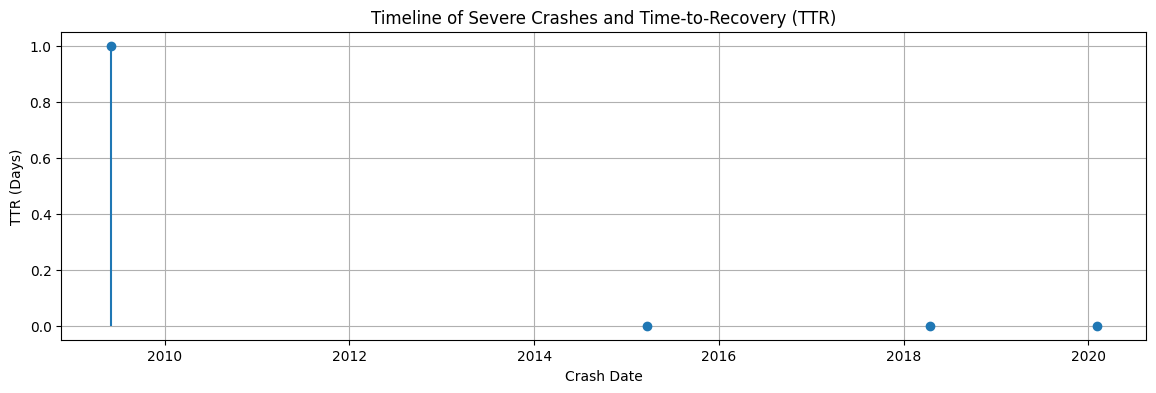


DESCRIPTION:
This stem plot visualizes when each severe crash occurred and how long recovery took.
Events with longer stems show prolonged instability after the crash.
Useful for historical pattern analysis of market shock duration.


In [66]:
sev_pd = severe_events.select(["ev_id","ev_date"]).to_pandas()
sev_pd["ev_date"] = pd.to_datetime(sev_pd["ev_date"])
evdate_map = dict(zip(sev_pd["ev_id"], sev_pd["ev_date"]))

df_timeline = severe_metrics.copy()
df_timeline["ev_date"] = df_timeline["ev_id"].map(evdate_map)

plt.figure(figsize=(14,4))
plt.stem(df_timeline["ev_date"], df_timeline["TTR"], basefmt=" ")
plt.title("Timeline of Severe Crashes and Time-to-Recovery (TTR)")
plt.xlabel("Crash Date")
plt.ylabel("TTR (Days)")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This stem plot visualizes when each severe crash occurred and how long recovery took.\n"
    "Events with longer stems show prolonged instability after the crash.\n"
    "Useful for historical pattern analysis of market shock duration."
)


/tmp/ipykernel_2034/2592872770.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


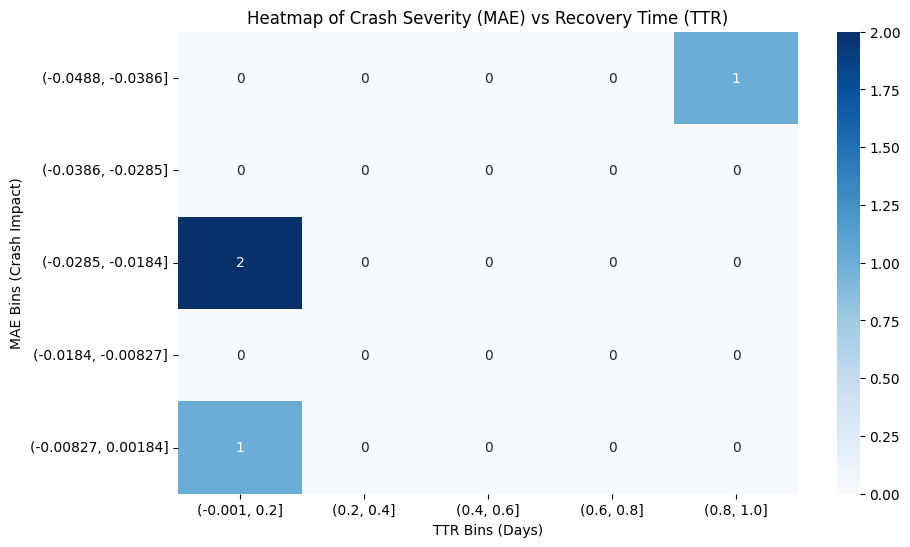


DESCRIPTION:
This heatmap shows the density of severe crashes across combinations of MAE and TTR.
Darker cells represent more events sharing similar impact and recovery characteristics.
It highlights whether deeper crashes tend to cluster in longer recovery ranges.


In [67]:
import numpy as np

# Prepare data: drop NaN TTR values
df_hm = severe_metrics.dropna(subset=["MAE", "TTR"]).copy()

# Bin MAE and TTR into categories for the heatmap
df_hm["MAE_bin"] = pd.cut(df_hm["MAE"], bins=5)
df_hm["TTR_bin"] = pd.cut(df_hm["TTR"], bins=5)

# Pivot for heatmap
heat_data = df_hm.pivot_table(
    index="MAE_bin", columns="TTR_bin", values="ev_id", aggfunc="count", fill_value=0
)

plt.figure(figsize=(10,6))
sns.heatmap(heat_data, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of Crash Severity (MAE) vs Recovery Time (TTR)")
plt.xlabel("TTR Bins (Days)")
plt.ylabel("MAE Bins (Crash Impact)")
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This heatmap shows the density of severe crashes across combinations of MAE and TTR.\n"
    "Darker cells represent more events sharing similar impact and recovery characteristics.\n"
    "It highlights whether deeper crashes tend to cluster in longer recovery ranges."
)


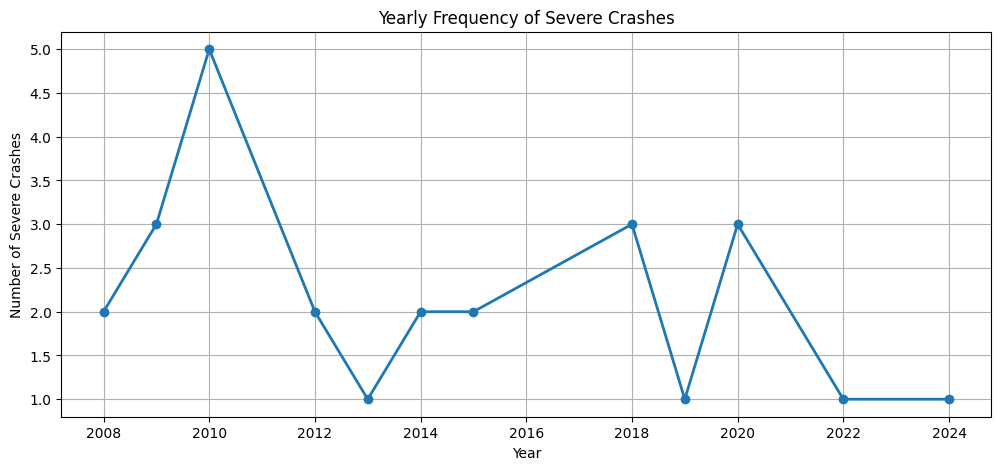


DESCRIPTION:
This line chart shows how many severe crashes occurred each year.
It helps identify active or quiet periods in aviation safety history.
Spikes may correspond to years with multiple major incidents.


In [68]:
# Convert to pandas year
sev_pd = severe_events.select(["ev_id", "ev_date"]).to_pandas()
sev_pd["ev_date"] = pd.to_datetime(sev_pd["ev_date"])
sev_pd["year"] = sev_pd["ev_date"].dt.year

year_counts = sev_pd["year"].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.plot(year_counts.index, year_counts.values, marker="o", linewidth=2)
plt.title("Yearly Frequency of Severe Crashes")
plt.xlabel("Year")
plt.ylabel("Number of Severe Crashes")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This line chart shows how many severe crashes occurred each year.\n"
    "It helps identify active or quiet periods in aviation safety history.\n"
    "Spikes may correspond to years with multiple major incidents."
)


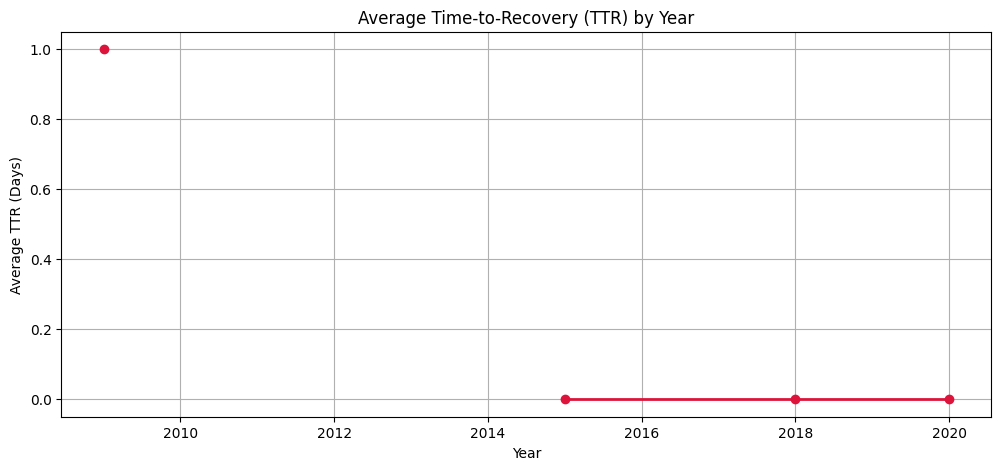


DESCRIPTION:
This chart shows how average recovery time changed year by year.
Higher values indicate years where crashes produced stronger or prolonged market reactions.
This helps identify structural shifts in investor sensitivity to aviation incidents.


In [69]:
df_merge = severe_metrics.merge(sev_pd[["ev_id","year"]], on="ev_id", how="left")

ttr_yearly = df_merge.groupby("year")["TTR"].mean()

plt.figure(figsize=(12,5))
plt.plot(ttr_yearly.index, ttr_yearly.values, marker="o", color="crimson", linewidth=2)
plt.title("Average Time-to-Recovery (TTR) by Year")
plt.xlabel("Year")
plt.ylabel("Average TTR (Days)")
plt.grid(True)
plt.show()

print(
    "\nDESCRIPTION:\n"
    "This chart shows how average recovery time changed year by year.\n"
    "Higher values indicate years where crashes produced stronger or prolonged market reactions.\n"
    "This helps identify structural shifts in investor sensitivity to aviation incidents."
)
